<img src='image.jpg'>

<h1 style=font-size:40px>Predicting Material Backorders in Inventory Management</h1>

[Please click on this link to view the research paper](https://www.researchgate.net/publication/319553365_Predicting_Material_Backorders_in_Inventory_Management_using_Machine_Learning)

Abstract—Material backorder is a common supply chain problem,
impacting an inventory system service level and effectiveness.
Identifying parts with the highest chances of shortage prior
its occurrence can present a high opportunity to improve an
overall company’s performance. In this paper, machine learning
classifiers are investigated in order to propose a predictive model
for this imbalanced class problem, where the relative frequency of
items that goes into backorder is rare when compared to items
that do not. Specific metrics such as area under the Receiver
Operator Characteristic and precision-recall curves, sampling
techniques and ensemble learning are employed in this particular
task.

The dataset has the follwing columns:

- sku: Stock Keeping Unit;
- national_inv: Current inventory level of component;
- lead_time: Registered transit time;
- in_transit_qty: In transit quantity;
- forecast_3_month: Forecast sales for the next 3 months;
- forecast_6_month: Forecast sales for the next 6 months;
- forecast_9_month: Forecast sales for the next 9 months;
- sales_1_month: Sales quantity for the prior 1 month;
- sales_3_month: Sales quantity for the prior 3 months;
- sales_6_month: Sales quantity for the prior 6 months;
- sales_9_month: Sales quantity for the prior 9 months;
- min_bank: Minimum recommended amount in stock;
- potential_issue: Indictor variable noting potential issue with item;
- pieces_past_due: Parts overdue from source;
- perf_6_month_avg: Source performance in last 6 months;
- perf_12_month_avg: Source performance in last 12 months;
- local_bo_qty: Amount of stock orders overdue;
- deck_risk: General risk flag;
- oe_constraint: General risk flag;
- ppap_risk: General risk flag;
- stop_auto_buy: General risk flag;
- rev_stop: General risk flag;
- went_on_backorder: Product went on backorder.

# Objective
Our goal is to predict if a product has gone into backorder or not based on the above features. This can be posed as a binary class classification problem in machine learning.

# Metrics
We are going to used accuracy for this case study. However, accuracy is not really a good measurement for a highly imbalanced dataset. Therefore, we will employ additional metrics like AUC curve which is specially designed for binary class classification. We are also going to use the confusion matrix along with precision and recall to better understand the model predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import kstest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("training_dataset_v2.csv")

In [3]:
test = pd.read_csv('test_dataset_v2.csv')

In [4]:
train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


In [5]:
test

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No


In [6]:
#dropping last row as everything is NaN
train = train[:-1]
test = test[:-1]

In [7]:
print(train.shape)
print(test.shape)

(1687860, 23)
(242075, 23)


In [8]:
train.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [9]:
test.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [10]:
#check for imbalanced data
train.loc[:,'went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

In [11]:
print(f"The ratio of positive class and negative class in the train set is: {int(11293/11293)}:{int(1676567/11293)}")

The ratio of positive class and negative class in the train set is: 1:148


In [12]:
test.loc[:,'went_on_backorder'].value_counts()

No     239387
Yes      2688
Name: went_on_backorder, dtype: int64

In [13]:
print(f"The ratio of positive class and negative class in the test set is: {int(2688/2688)}:{int(239387/2688)}")

The ratio of positive class and negative class in the test set is: 1:89


In [14]:
#checking all the features which have missing values
train.isnull().any()

sku                  False
national_inv         False
lead_time             True
in_transit_qty       False
forecast_3_month     False
forecast_6_month     False
forecast_9_month     False
sales_1_month        False
sales_3_month        False
sales_6_month        False
sales_9_month        False
min_bank             False
potential_issue      False
pieces_past_due      False
perf_6_month_avg     False
perf_12_month_avg    False
local_bo_qty         False
deck_risk            False
oe_constraint        False
ppap_risk            False
stop_auto_buy        False
rev_stop             False
went_on_backorder    False
dtype: bool

In [15]:
test.isnull().any()

sku                  False
national_inv         False
lead_time             True
in_transit_qty       False
forecast_3_month     False
forecast_6_month     False
forecast_9_month     False
sales_1_month        False
sales_3_month        False
sales_6_month        False
sales_9_month        False
min_bank             False
potential_issue      False
pieces_past_due      False
perf_6_month_avg     False
perf_12_month_avg    False
local_bo_qty         False
deck_risk            False
oe_constraint        False
ppap_risk            False
stop_auto_buy        False
rev_stop             False
went_on_backorder    False
dtype: bool

In [16]:
#how many null values in lead_time (train set)?
train.loc[:,'lead_time'].isnull().value_counts()

False    1586967
True      100893
Name: lead_time, dtype: int64

In [17]:
#percentage of null values of lead_time in train set
lead_time_null_per_train = (train.loc[:,'lead_time'].isnull().value_counts()[1]/train.shape[0]) * 100
print("The percentage of null values in the lead_time feature in train set is:", lead_time_null_per_train)

The percentage of null values in the lead_time feature in train set is: 5.9775692296754475


In [18]:
#how many null values in lead_time (test set)?
test.loc[:,'lead_time'].isnull().value_counts()

False    227351
True      14724
Name: lead_time, dtype: int64

In [19]:
#percentage of null values of lead_time in train set
lead_time_null_per_test = (test.loc[:,'lead_time'].isnull().value_counts()[1]/test.shape[0]) * 100
print("The percentage of null values in the lead_time feature in test set is:", lead_time_null_per_test)

The percentage of null values in the lead_time feature in test set is: 6.082412475472478


In [20]:
#categorical features for train set
train.select_dtypes(include=['category', object]).columns

Index(['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
       'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [21]:
#categorical features for test set
test.select_dtypes(include=['category', object]).columns

Index(['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
       'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

#### Observations: 
At the first look of both the train and test data, we see that there are 23 features including the class label (went_on_backorder). It is highly imbalanced dataset with positive classes (11293) being very less compared to the negative classes (1676567) in the training set. The ration of the positive class and negative class in the train dataset is 1:148.

We observe that the feature "lead_time" has a few missing values. There are about 5.97% of data point containing null values in the train set and about 6.08% of data points containing null values in the test set. 

Among all the features, 'sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop' and 'went_on_backorder' are considered as categorical features. However, 'sku' is supposed to be the identifier and 'went_on_backorder' is the class label. Therefore, we would be dropping them both.

In [22]:
#dropping sku column
train.drop('sku', axis=1, inplace=True)

In [23]:
train.head(2)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No


In [24]:
train.shape

(1687860, 22)

In [25]:
train.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


## Exploratory Data Analysis

Let's start with univariate analysis of the features. We will be switching to bivariate or multivariate analysis whenever it is necessary.

####  national_inv vs went_on_backorder

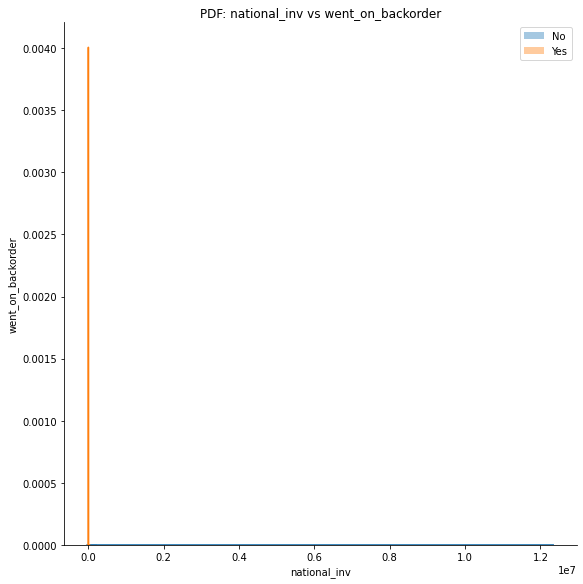

In [26]:
#feature = "national_inv"
sns.FacetGrid(train, hue="went_on_backorder", height=8).map(sns.distplot, "national_inv")
plt.title('PDF: national_inv vs went_on_backorder')
plt.xlabel('national_inv')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

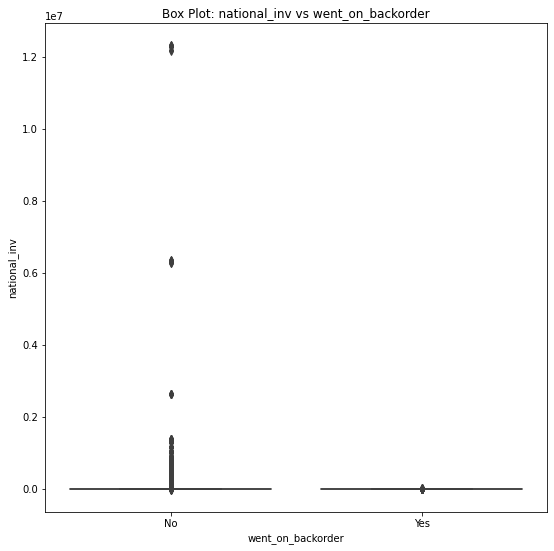

In [27]:
#box-plot for national_inv vs went_on_backorder
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='national_inv', data=train)
plt.title('Box Plot: national_inv vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('national_inv')
plt.show()

In [28]:
#applying log on national_inv and a small epsilon as there are zeros values. log(0) = inf. we don't want inf on our plot.
epsilon = 1e-7
log_national_inv = np.log(train['national_inv'] + epsilon)

In [29]:
train['log_national_inv'] = log_national_inv

In [30]:
train.head(2)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,log_national_inv
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,-99.00,0.0,No,No,No,Yes,No,No,-16.118096
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.99,0.0,No,No,No,Yes,No,No,0.693147


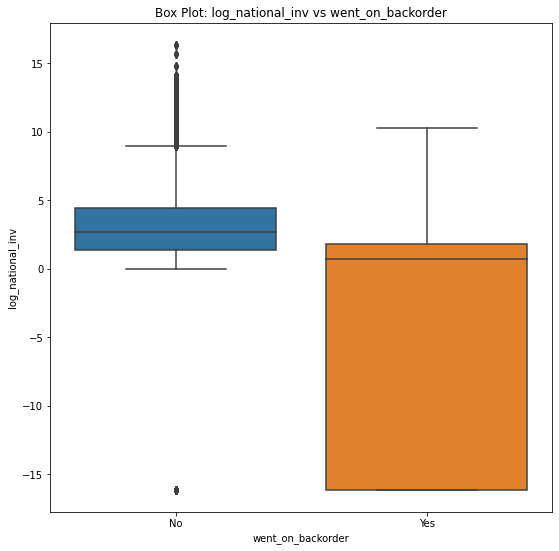

In [31]:
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='log_national_inv', data=train)
plt.title('Box Plot: log_national_inv vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('log_national_inv')
plt.show()

In [32]:
train.drop('log_national_inv', axis=1, inplace=True) #dropping off the log column as it is not useful for us

#### Observations:
From the initial plots, it is evident that there are a lot of outliers and the distritution is extremely skewed towards the positive side. However, we are unable to properly see that the Inter Quartile Range (IQR) for both the box plots. Therefore, we have modified the national_inv to show it's log values. And since there are zero values in the feature, we have added a small value 'epsilon' which is 1e-7, to avoid infinity.

From the box plot of the logarithm of national_inv, we see that the IQRs are now visible. The median and the maximums for both the classes seems to be similar but the IQRs themselves vary a lot. We still do see outliers for the feature, especially for the negative class label. 

With regard to the positive class, we quickly observe that there is no seperate minimum. The minimum seems to be same as the 25th percentile. And the number of points lying between the 25th percentile and the median is quite large compared to the median and the 75th percentile.

####  lead_time vs went_on_backorder

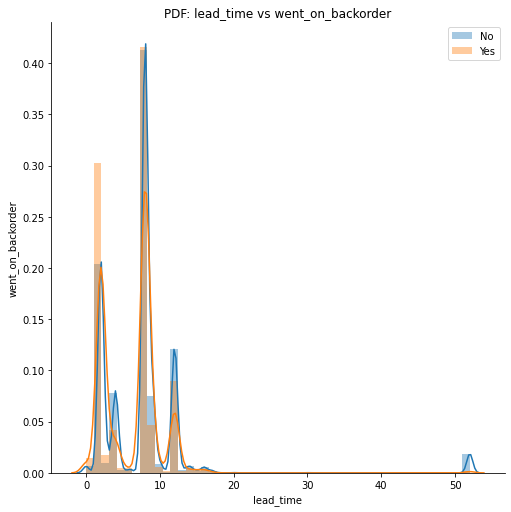

In [33]:
#feature = "lead_time"
sns.FacetGrid(train.dropna(), hue="went_on_backorder", height=7).map(sns.distplot, "lead_time")
plt.title('PDF: lead_time vs went_on_backorder')
plt.xlabel('lead_time')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

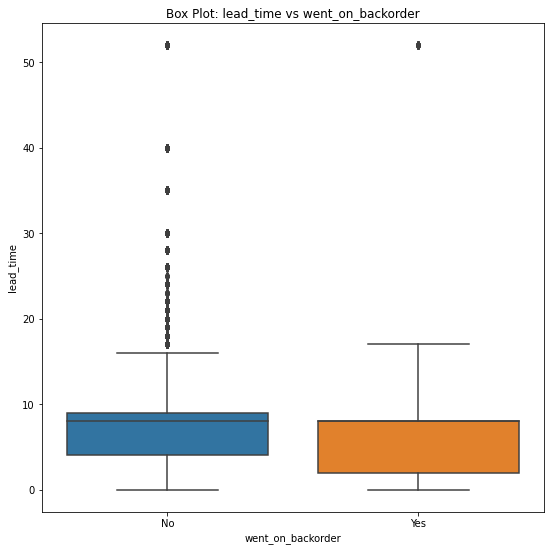

In [34]:
#box-plot for lead_time vs went_on_backorder
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='lead_time', data=train.dropna())
plt.title('Box Plot: lead_time vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('lead_time')
plt.show()

#### Observations:

To analyze this feature, we have dropped all NaN values. We see that the feature is not normally distributed as per the first pdf plot. There is a lot of overlap and we see that the are a lot of datapoints spread towards the right side of the graph which means skewness. The feature 'lead_time' is extremely skewed towards the positive side. 

When we look at the box plot, we see that there is no distinct median for the positive class. The median seems to have been merged into the Q1 value. Therefore, we can say that most of the datapoints in the feature is that one value at Q1 for the positive class. Howver, for the negative class we see the median but it is closer to the Q3 value. Here as well, we see a skewness but due to outliers.

The minumum for both the classes seem to be similar. We also see many outlier here, especially for the negative class.

####  in_transit_qty vs went_on_backorder

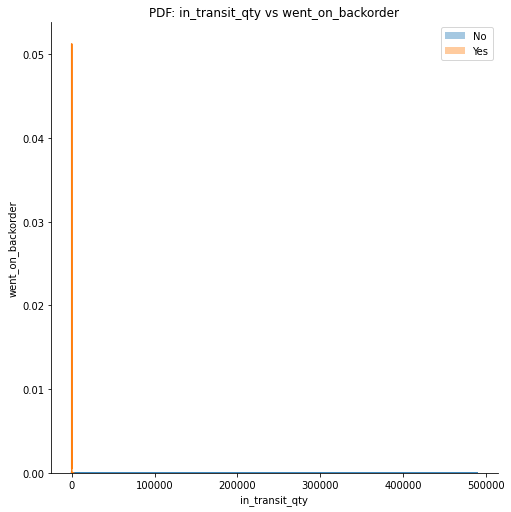

In [35]:
#feature = "in_transit_qty"
sns.FacetGrid(train, hue="went_on_backorder", height=7).map(sns.distplot, "in_transit_qty")
plt.title('PDF: in_transit_qty vs went_on_backorder')
plt.xlabel('in_transit_qty')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

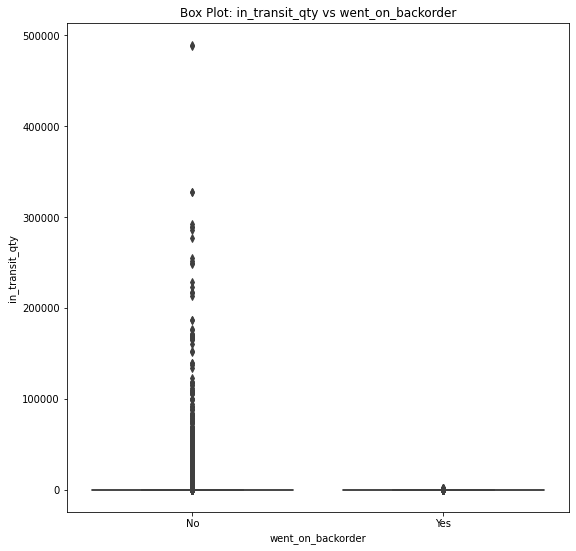

In [36]:
#box-plot for in_transit_qty vs went_on_backorder
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='in_transit_qty', data=train)
plt.title('Box Plot: in_transit_qty vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('in_transit_qty')
plt.show()

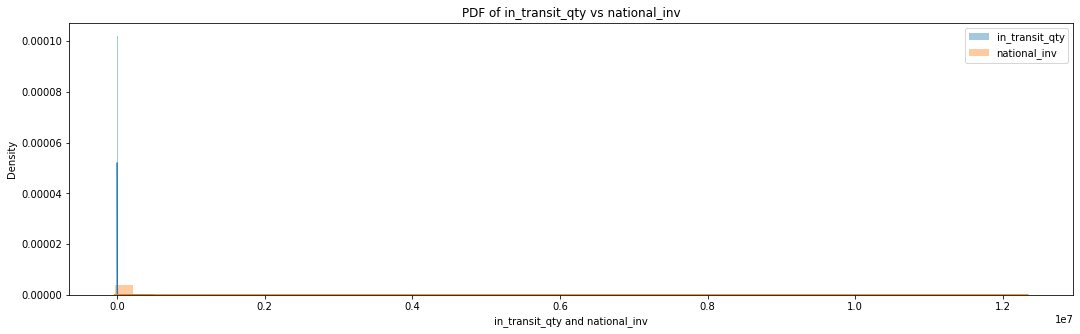

In [37]:
plt.figure(figsize=(18,5))
sns.distplot(train['in_transit_qty'], label='in_transit_qty')
sns.distplot(train['national_inv'], label='national_inv')
plt.title("PDF of in_transit_qty vs national_inv")
plt.xlabel("in_transit_qty and national_inv")
plt.legend()
plt.show()

In [38]:
#again adding a small epsilon value and converting into log scale
log_in_transit_qty = np.log(train['in_transit_qty'] + epsilon)

train['log_in_transit_qty'] = log_in_transit_qty

In [39]:
train.head(2)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,log_in_transit_qty
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,-99.00,0.0,No,No,No,Yes,No,No,-16.118096
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.99,0.0,No,No,No,Yes,No,No,-16.118096


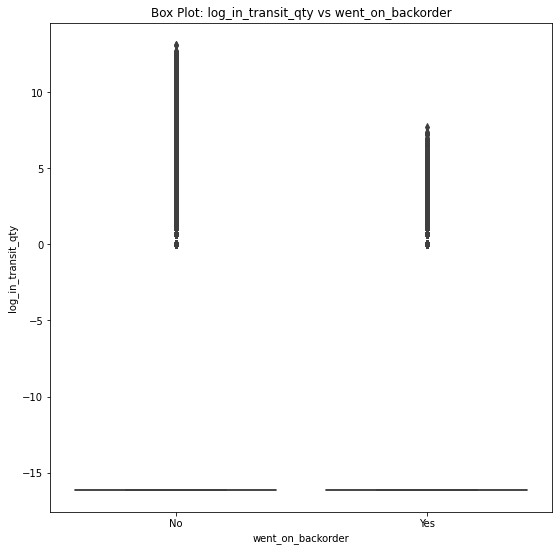

In [40]:
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='log_in_transit_qty', data=train)
plt.title('Box Plot: log_in_transit_qty vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('log_in_transit_qty')
plt.show()

In [41]:
train.drop('log_in_transit_qty', axis=1, inplace=True) #dropping off the log column as it is not useful for us

In [42]:
#as the above plots show that outliers are heavely impacting the distribution
#we will now try to find the mean, median and quantiles for better understanding
print("The mean of the in_transit_qty is :", np.mean(train["in_transit_qty"]))

The mean of the in_transit_qty is : 44.05202208713993


In [43]:
print("The median of the in_transit_qty is :", np.median(train["in_transit_qty"]))

The median of the in_transit_qty is : 0.0


In [44]:
#percentiles and quantiles for in_transit_qty
print("Quantiles for in_transit_qty:")
print("25th percentile:",np.percentile(train["in_transit_qty"],25)) #25th percentile
print("50th percentile:",np.percentile(train["in_transit_qty"],50)) #50th percentile or median
print("75th percentile:",np.percentile(train["in_transit_qty"],75)) #75th percentile
print("80th percentile:",np.percentile(train["in_transit_qty"],80)) #80th percentile
print("85th percentile:",np.percentile(train["in_transit_qty"],85)) #85th percentile
print("89th percentile:",np.percentile(train["in_transit_qty"],89)) #89th percentile
print("90th percentile:",np.percentile(train["in_transit_qty"],90)) #90th percentile

Quantiles for in_transit_qty:
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 0.0
80th percentile: 1.0
85th percentile: 4.0
89th percentile: 12.0
90th percentile: 16.0


In [45]:
print("The maximum value of in_transit_qty is", max(train["in_transit_qty"]))

The maximum value of in_transit_qty is 489408.0


#### Observations:
We see from the above plots 'PDF: in_transit_qty vs went_on_backorder' and 'Box Plot: in_transit_qty vs went_on_backorder' that the distribution of in_transit_quantity is a bit similar to national_inv. Hence, to further investigate that, we have plotted an additional plot for comparing PDFs of 'in_transit_qty' and 'national_inv'. We quickly see that our assumption is partially right. Both the features are positively skewed.

On the initial box plot, we see that there are a bunch of outliers and we are unable to see the IQR properly, we have employed the same alternative step as national_inv. We have added a small epsilon value to not get any infinity values while converting to the log scale. The box plot of the logarithm of 'in_transit_qty' clearly shows the impact of outliers to be very large. We are still unable to see the IQR of 'in_transit_qty' properly.

Therefore, we have computed the mean, median and quantiles manually to better understand the data. The mean of in_transit_qty is 44.05202208713993 while the median is 0.0. As we know that median is robust to outliers while the mean is succeptible to outliers, we can be certain that outliers have a hugh impact on the feature. In addition, if we obsereve the quantiles, the 25th, 50th and 75th percentiles are all zero. We can say that 75% of the datapoints are equal to zero. And 90% of the point are less than or equal to 16 while the maximum value is 489408. That is a very large margin for the other 10% of the points.

Finally, we can say that no quantity of products are in transit 75% percent of the time.

####  forecast_3_month, forecast_6_month and forecast_9_month vs went_on_backorder

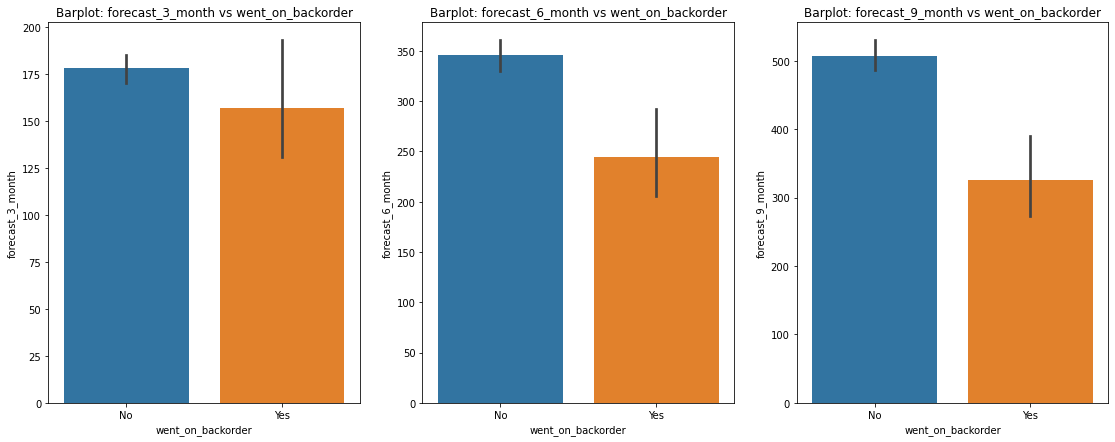

In [46]:
plt.figure(figsize=(19, 7))

plt.subplot(1, 3, 1)
sns.barplot(x='went_on_backorder', y='forecast_3_month', orient='v', data=train)
plt.title('Barplot: forecast_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_3_month')

plt.subplot(1, 3, 2)
sns.barplot(x='went_on_backorder', y='forecast_6_month', orient='v', data=train)
plt.title('Barplot: forecast_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_6_month')

plt.subplot(1, 3, 3)
sns.barplot(x='went_on_backorder', y='forecast_9_month', orient='v', data=train)
plt.title('Barplot: forecast_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_9_month')

plt.show()

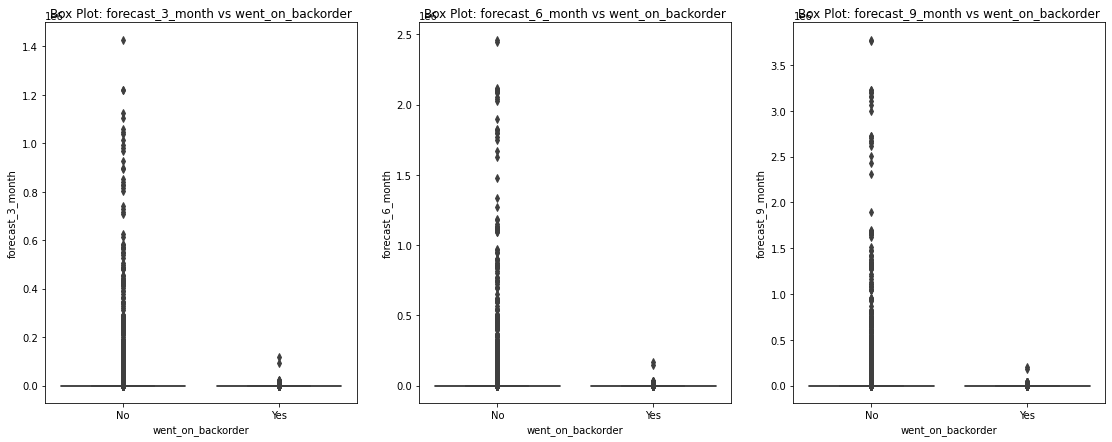

In [47]:
plt.figure(figsize=(19, 7))

plt.subplot(1, 3, 1)
sns.boxplot(x='went_on_backorder', y='forecast_3_month', data=train)
plt.title('Box Plot: forecast_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_3_month')

plt.subplot(1, 3, 2)
sns.boxplot(x='went_on_backorder', y='forecast_6_month', data=train)
plt.title('Box Plot: forecast_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_6_month')

plt.subplot(1, 3, 3)
sns.boxplot(x='went_on_backorder', y='forecast_9_month', data=train)
plt.title('Box Plot: forecast_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_9_month')

plt.show()

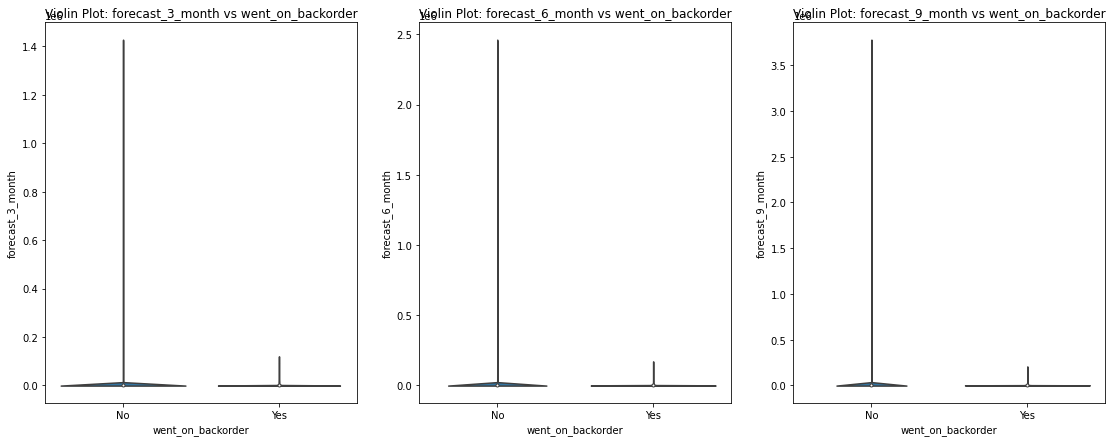

In [48]:
plt.figure(figsize=(19, 7))

plt.subplot(1, 3, 1)
sns.violinplot(x='went_on_backorder', y='forecast_3_month', data=train)
plt.title('Violin Plot: forecast_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_3_month')

plt.subplot(1, 3, 2)
sns.violinplot(x='went_on_backorder', y='forecast_6_month', data=train)
plt.title('Violin Plot: forecast_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_6_month')

plt.subplot(1, 3, 3)
sns.violinplot(x='went_on_backorder', y='forecast_9_month', data=train)
plt.title('Violin Plot: forecast_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('forecast_9_month')

plt.show()

In [49]:
#percentiles and quantiles
print("Quantiles for forecast_3_month:")
print("25th percentile:",np.percentile(train["forecast_3_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["forecast_3_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["forecast_3_month"],60)) #50th percentile
print("65th percentile:",np.percentile(train["forecast_3_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["forecast_3_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["forecast_3_month"],90)) #90th percentile

print("Quantiles for forecast_6_month:")
print("25th percentile:",np.percentile(train["forecast_6_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["forecast_6_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["forecast_6_month"],60)) #50th percentile
print("65th percentile:",np.percentile(train["forecast_6_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["forecast_6_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["forecast_6_month"],90)) #90th percentile

print("Quantiles for forecast_9_month:")
print("25th percentile:",np.percentile(train["forecast_9_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["forecast_9_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["forecast_9_month"],60)) #50th percentile 
print("65th percentile:",np.percentile(train["forecast_9_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["forecast_9_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["forecast_9_month"],90)) #90th percentile

Quantiles for forecast_3_month:
25th percentile: 0.0
50th percentile: 0.0
60th percentile: 0.0
65th percentile: 0.0
75th percentile: 4.0
90th percentile: 83.0
Quantiles for forecast_6_month:
25th percentile: 0.0
50th percentile: 0.0
60th percentile: 0.0
65th percentile: 1.0
75th percentile: 12.0
90th percentile: 176.0
Quantiles for forecast_9_month:
25th percentile: 0.0
50th percentile: 0.0
60th percentile: 0.0
65th percentile: 3.0
75th percentile: 20.0
90th percentile: 261.0


#### Observations:
The bar plots represents an estimate of central tendency (in this case mean). Therefore, from the set of bar plots, we can say that the over a span of 3, 6 and 9 months, the mean forecast sales is decreasing as a whole for the positive class while the mean forecast sales seems to be constant for the negative class.

To understand the distrubutions and IQRs, we have plotted the box plots and violin plots. We see that the IQRs are not visible here as well. And there are a lot of outliers expecially for the negative class for all the 3 features. And the range of the forecast of outiers only seems to increase for the future months. The is kind of expected as the number of orders increase with time. From the violin plot, we see that the distributions of all the three features are similar, with all being positively skewed extremely. 

We also see that atleast 60th percentile of the datapoints are equal to zero for all the three features 'forecast_3_month', 'forecast_3_month' and 'forecast_9_month'. And there is a large margin between 90% percentile and the maximum values for the three features which again indicates outliers.

####  sales_1_month, sales_3_month, sales_6_month and sales_9_month vs went_on_backorder

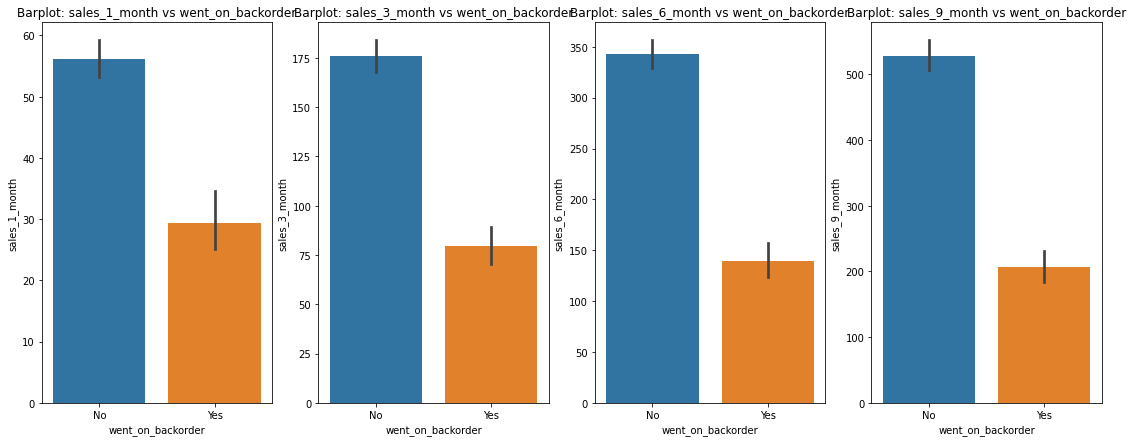

In [50]:
plt.figure(figsize=(19, 7))

plt.subplot(1, 4, 1)
sns.barplot(x='went_on_backorder', y='sales_1_month', orient='v', data=train)
plt.title('Barplot: sales_1_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_1_month')

plt.subplot(1, 4, 2)
sns.barplot(x='went_on_backorder', y='sales_3_month', orient='v', data=train)
plt.title('Barplot: sales_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_3_month')

plt.subplot(1, 4, 3)
sns.barplot(x='went_on_backorder', y='sales_6_month', orient='v', data=train)
plt.title('Barplot: sales_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_6_month')

plt.subplot(1, 4, 4)
sns.barplot(x='went_on_backorder', y='sales_9_month', orient='v', data=train)
plt.title('Barplot: sales_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_9_month')

plt.show()

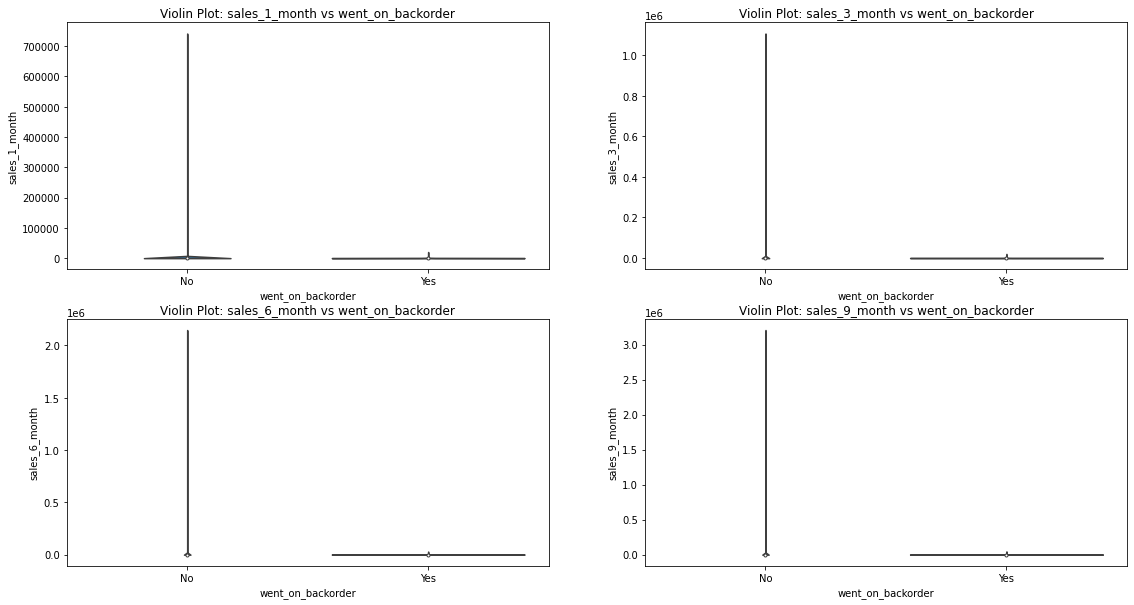

In [51]:
plt.figure(figsize=(19, 10))

plt.subplot(2, 2, 1)
sns.violinplot(x='went_on_backorder', y='sales_1_month', data=train)
plt.title('Violin Plot: sales_1_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_1_month')

plt.subplot(2, 2, 2)
sns.violinplot(x='went_on_backorder', y='sales_3_month', data=train)
plt.title('Violin Plot: sales_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_3_month')

plt.subplot(2, 2, 3)
sns.violinplot(x='went_on_backorder', y='sales_6_month', data=train)
plt.title('Violin Plot: sales_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_6_month')

plt.subplot(2, 2, 4)
sns.violinplot(x='went_on_backorder', y='sales_9_month', data=train)
plt.title('Violin Plot: sales_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_9_month')

plt.show()

In [52]:
#percentiles and quantiles
print("Quantiles for sales_1_month:")
print("25th percentile:",np.percentile(train["sales_1_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["sales_1_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["sales_1_month"],60)) #50th percentile
print("65th percentile:",np.percentile(train["sales_1_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["sales_1_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["sales_1_month"],90)) #90th percentile

print("Quantiles for sales_3_month:")
print("25th percentile:",np.percentile(train["sales_3_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["sales_3_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["sales_3_month"],60)) #50th percentile
print("65th percentile:",np.percentile(train["sales_3_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["sales_3_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["sales_3_month"],90)) #90th percentile

print("Quantiles for sales_6_month:")
print("25th percentile:",np.percentile(train["sales_6_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["sales_6_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["sales_6_month"],60)) #50th percentile 
print("65th percentile:",np.percentile(train["sales_6_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["sales_6_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["sales_6_month"],90)) #90th percentile

print("Quantiles for sales_9_month:")
print("25th percentile:",np.percentile(train["sales_9_month"],25)) #25th percentile
print("50th percentile:",np.percentile(train["sales_9_month"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["sales_9_month"],60)) #50th percentile 
print("65th percentile:",np.percentile(train["sales_9_month"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["sales_9_month"],75)) #75th percentile
print("90th percentile:",np.percentile(train["sales_9_month"],90)) #90th percentile

Quantiles for sales_1_month:
25th percentile: 0.0
50th percentile: 0.0
60th percentile: 1.0
65th percentile: 1.0
75th percentile: 4.0
90th percentile: 34.0
Quantiles for sales_3_month:
25th percentile: 0.0
50th percentile: 1.0
60th percentile: 3.0
65th percentile: 5.0
75th percentile: 15.0
90th percentile: 114.0
Quantiles for sales_6_month:
25th percentile: 0.0
50th percentile: 2.0
60th percentile: 7.0
65th percentile: 11.0
75th percentile: 31.0
90th percentile: 232.0
Quantiles for sales_9_month:
25th percentile: 0.0
50th percentile: 4.0
60th percentile: 10.0
65th percentile: 16.0
75th percentile: 47.0
90th percentile: 355.0


In [53]:
#removing outliers
modified_train = train[train['sales_1_month'] < 4] # removing entire Q4 for sales_1_month
modified_train = modified_train[modified_train['sales_3_month'] < 15] # removing entire Q4 for sales_3_month
modified_train = modified_train[modified_train['sales_6_month'] < 31] # same as above
modified_train = modified_train[modified_train['sales_9_month'] < 47]

In [54]:
modified_train.shape

(1190306, 22)

In [55]:
modified_train['sales_1_month'].unique()

array([0., 1., 2., 3.])

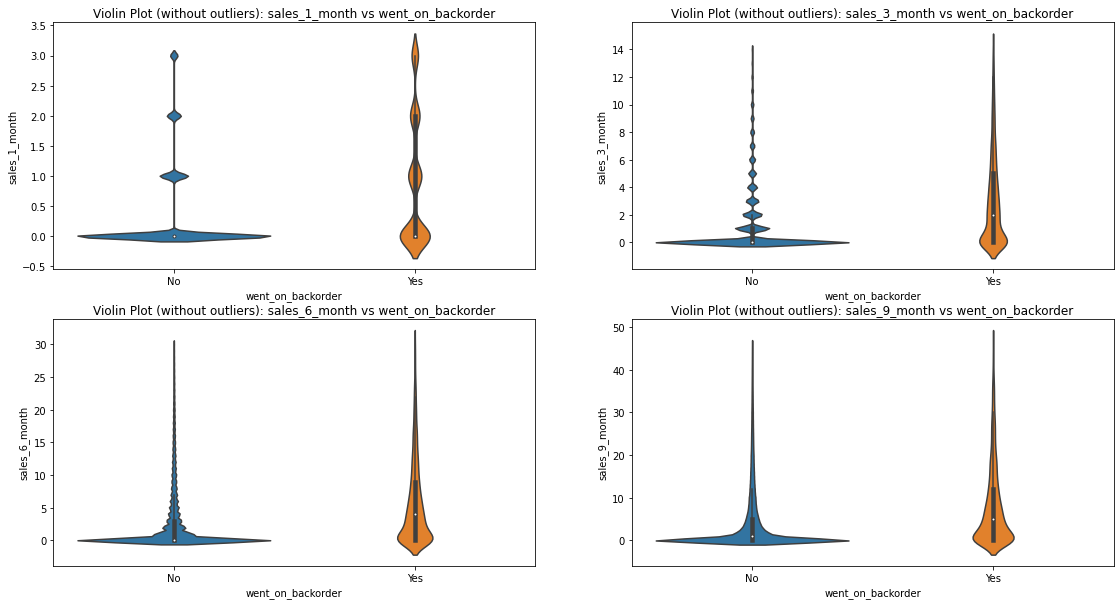

In [56]:
plt.figure(figsize=(19, 10))

plt.subplot(2, 2, 1)
sns.violinplot(x='went_on_backorder', y='sales_1_month', data=modified_train)
plt.title('Violin Plot (without outliers): sales_1_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_1_month')

plt.subplot(2, 2, 2)
sns.violinplot(x='went_on_backorder', y='sales_3_month', data=modified_train)
plt.title('Violin Plot (without outliers): sales_3_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_3_month')

plt.subplot(2, 2, 3)
sns.violinplot(x='went_on_backorder', y='sales_6_month', data=modified_train)
plt.title('Violin Plot (without outliers): sales_6_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_6_month')

plt.subplot(2, 2, 4)
sns.violinplot(x='went_on_backorder', y='sales_9_month', data=modified_train)
plt.title('Violin Plot (without outliers): sales_9_month vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('sales_9_month')

plt.show()

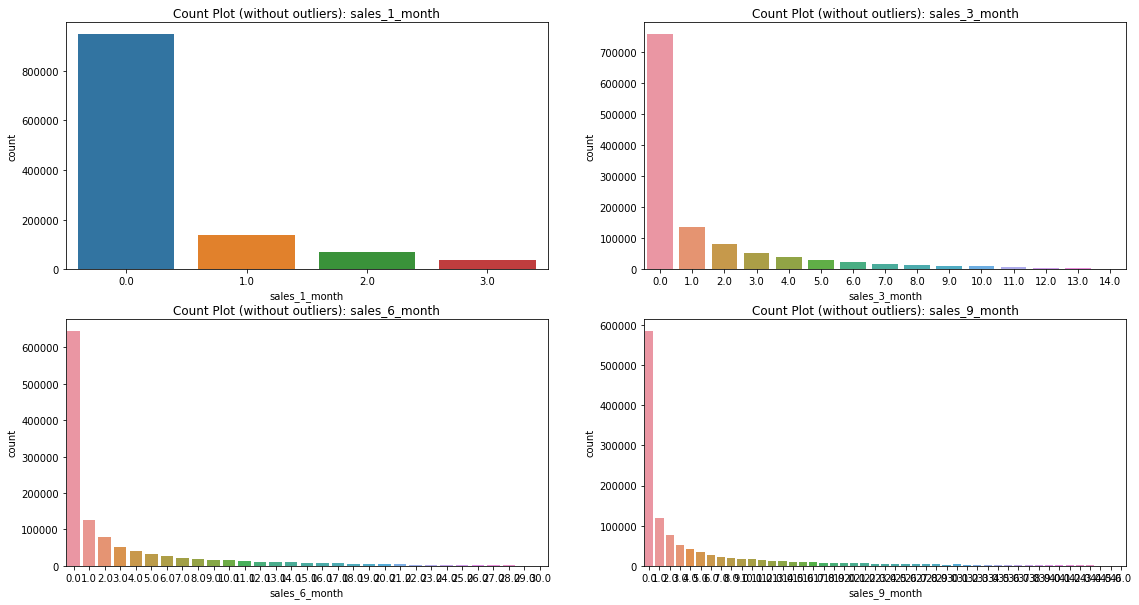

In [57]:
#count plots for all the four features
plt.figure(figsize=(19, 10))

plt.subplot(2, 2, 1)
sns.countplot(modified_train['sales_1_month'])
plt.title('Count Plot (without outliers): sales_1_month')

plt.subplot(2, 2, 2)
sns.countplot(modified_train['sales_3_month'])
plt.title('Count Plot (without outliers): sales_3_month')

plt.subplot(2, 2, 3)
sns.countplot(modified_train['sales_6_month'])
plt.title('Count Plot (without outliers): sales_6_month')

plt.subplot(2, 2, 4)
sns.countplot(modified_train['sales_9_month'])
plt.title('Count Plot (without outliers): sales_9_month')

plt.show()

#### Observations:
From the first set of barplots, we understand that the mean number of orders that went into backorder over a span of a few months decreases as the number of orders increase. The violin plots indicate that the distributions are skewed. 

When we look at the percentiles, we see that atleast 25% of the datapoints are equal to zero for all the four features and the 90th percentiles seems to have very high values compared to the the rest.

To understand that data better, we have removed the entire Q4 for all the four features and have plotted violin plots. We can now clearly see that the distributions are all skewed towards the positive side and all the data points seems to be positive integers only. Therefore, we have also plotted a count plot to understand the relationship between the count of sales quantity for all the four features. 

We quickly see that there are a lot of products with zero number of units sold in all the prior months. Datapoints with atleast one unit sold are more compared to datapoints with atleast 3 units sold for the feature 'sales_1_month'. An extended version of this is true for all the other features i.e., datapoints with atleast one unit sold are more compared to datapoints with atleast 3 or more units sold. 

As we look at sales quantity the prior 9 months, we see that the number of units sold are greater than the sales quantity for the prior 3 or 6 months, which is ideal. 

####  min_bank vs went_on_backorder

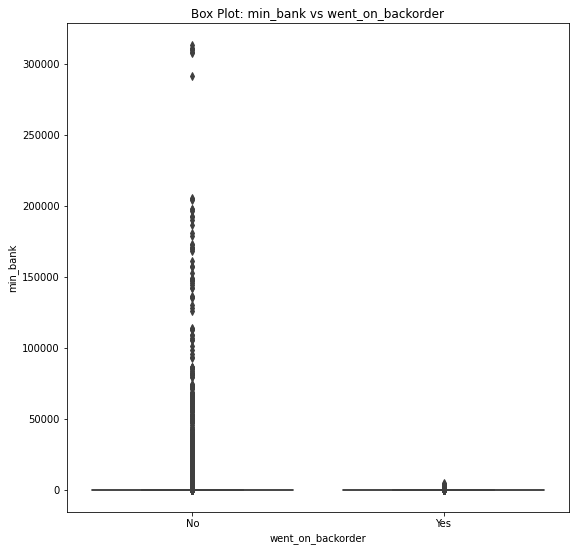

In [58]:
plt.figure(figsize=(9, 9))
sns.boxplot(x='went_on_backorder', y='min_bank', data=train)
plt.title('Box Plot: min_bank vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('min_bank')
plt.show()

In [59]:
print("Quantiles for min_bank:")
print("25th percentile:",np.percentile(train["min_bank"],25)) #25th percentile
print("50th percentile:",np.percentile(train["min_bank"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["min_bank"],60)) #50th percentile
print("65th percentile:",np.percentile(train["min_bank"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["min_bank"],75)) #75th percentile
print("80th percentile:",np.percentile(train["min_bank"],80)) #80th percentile
print("85th percentile:",np.percentile(train["min_bank"],85)) #85th percentile
print("90th percentile:",np.percentile(train["min_bank"],90)) #90th percentile

Quantiles for min_bank:
25th percentile: 0.0
50th percentile: 0.0
60th percentile: 1.0
65th percentile: 1.0
75th percentile: 3.0
80th percentile: 10.0
85th percentile: 23.0
90th percentile: 46.0


In [60]:
# removing all data points above 80th percentile 
modified_train = train[train['min_bank'] < 10]

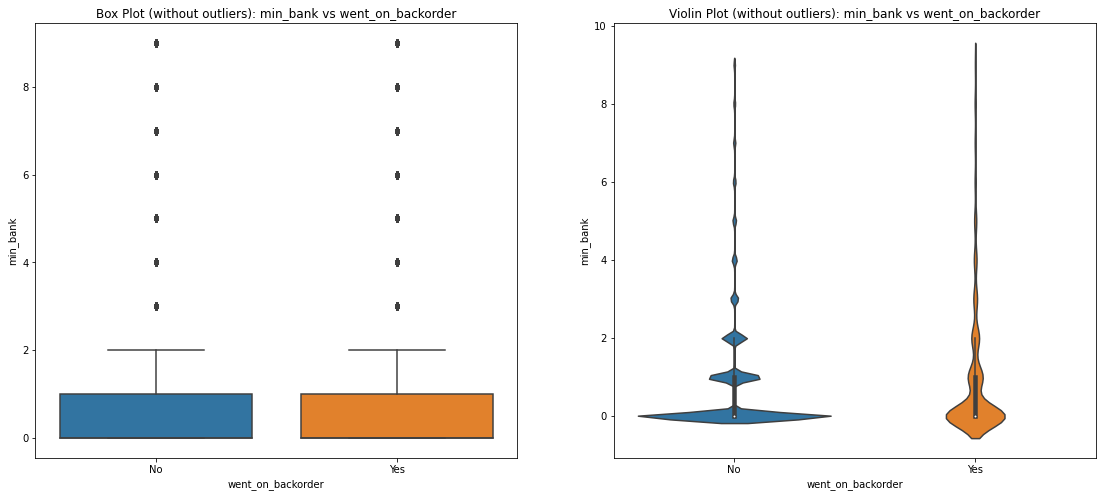

In [61]:
plt.figure(figsize=(19, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='went_on_backorder', y='min_bank', data=modified_train)
plt.title('Box Plot (without outliers): min_bank vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('min_bank')

plt.subplot(1, 2, 2)
sns.violinplot(x='went_on_backorder', y='min_bank', data=modified_train)
plt.title('Violin Plot (without outliers): min_bank vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('min_bank')

plt.show()

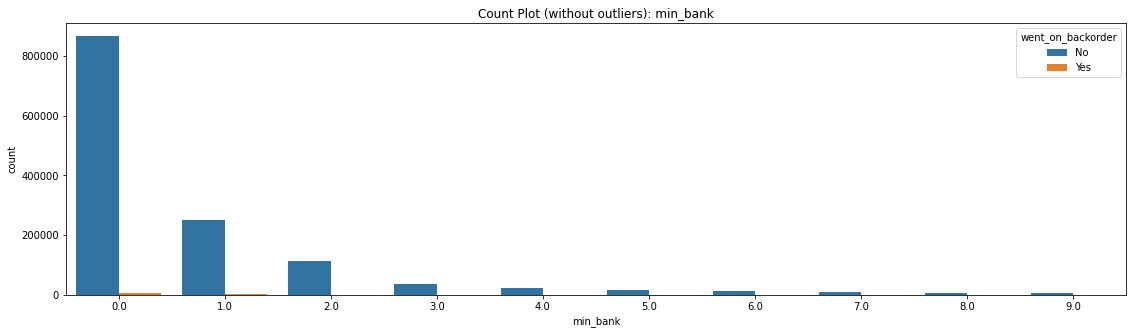

In [62]:
plt.figure(figsize=(19, 5))
sns.countplot(modified_train['min_bank'], hue=modified_train['went_on_backorder'])
plt.title('Count Plot (without outliers): min_bank')
plt.show()

#### Observations:
From the box plot, we understand that most of the values tend to be zero. This statement is true is we check the quartiles. Atleast 50% of the data points are zero which means the median value of the feature is zero. We have tried to remove the datapoints above 80% percentile and have plotted box and a violin plot. If we observe these plots we see that the values are positive integers and the maximum value that is not considered an outlier is 2. 

From the count plot also, we can make the same deductions that most of the values tend to be zero and there are very less data points with a min_bank value of of 3 or more. 

#### potential_issue vs went_on_backorder

In [63]:
train['potential_issue'].unique()

array(['No', 'Yes'], dtype=object)

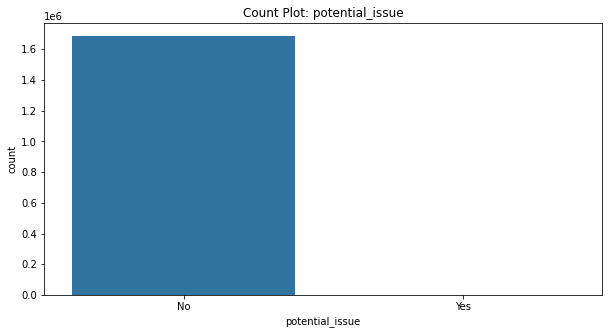

In [64]:
plt.figure(figsize=(10, 5))

sns.countplot(train['potential_issue'])
plt.title('Count Plot: potential_issue')

plt.show()

#### Observations:
We see that the feature potential_issue is a categorical feature. From the count plot we understand that the count of datapoints whch have a potential issue is far less that the count of datapoints which do not have any potential issue. 

#### pieces_past_due vs went_on_backorder

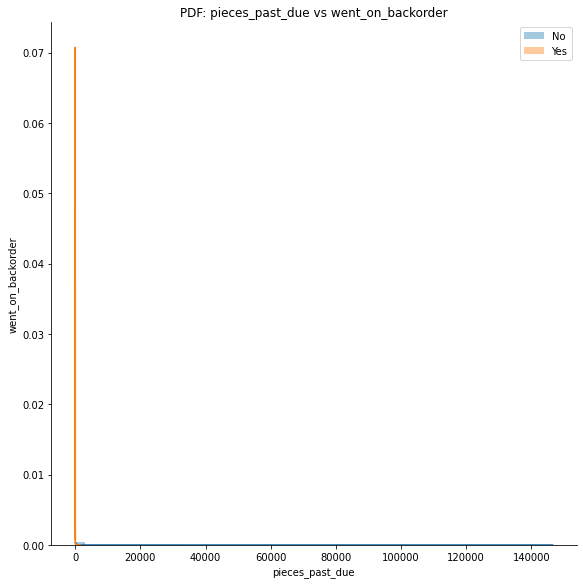

In [65]:
sns.FacetGrid(train, hue="went_on_backorder", height=8).map(sns.distplot, "pieces_past_due")
plt.title('PDF: pieces_past_due vs went_on_backorder')
plt.xlabel('pieces_past_due')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

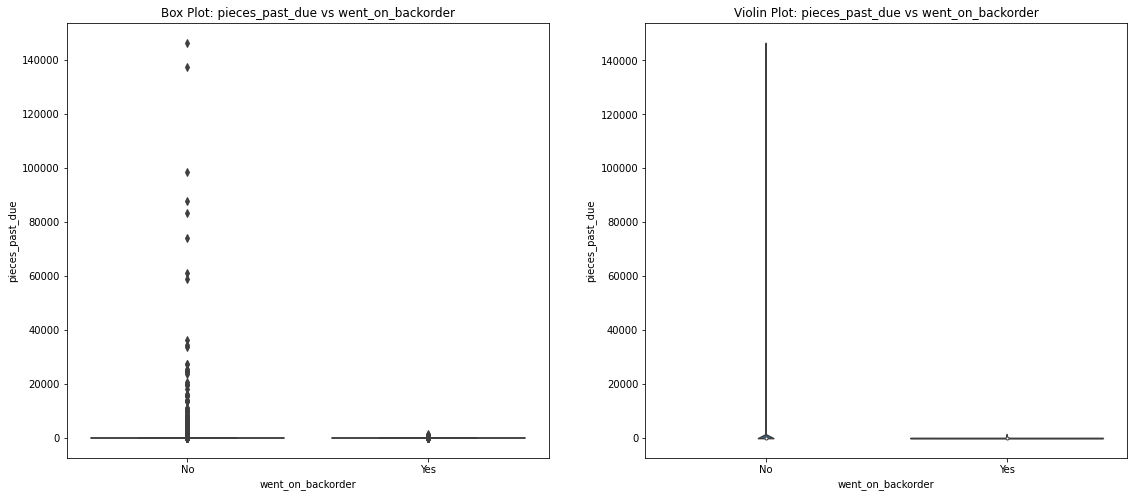

In [66]:
plt.figure(figsize=(19, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='went_on_backorder', y='pieces_past_due', data=train)
plt.title('Box Plot: pieces_past_due vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('pieces_past_due')

plt.subplot(1, 2, 2)
sns.violinplot(x='went_on_backorder', y='pieces_past_due', data=train)
plt.title('Violin Plot: pieces_past_due vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('pieces_past_due')

plt.show()

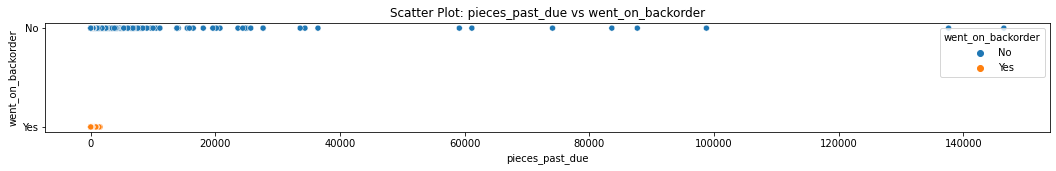

In [67]:
plt.figure(figsize=(18, 2))

sns.scatterplot(x='pieces_past_due', y='went_on_backorder', hue='went_on_backorder', data=train)
plt.title('Scatter Plot: pieces_past_due vs went_on_backorder')
plt.xlabel('pieces_past_due')
plt.ylabel('went_on_backorder')
plt.show()

In [68]:
print("Quantiles for pieces_past_due:")
print("25th percentile:",np.percentile(train["pieces_past_due"],25)) #25th percentile
print("50th percentile:",np.percentile(train["pieces_past_due"],50)) #50th percentile or median
print("75th percentile:",np.percentile(train["pieces_past_due"],75)) #75th percentile
print("90th percentile:",np.percentile(train["pieces_past_due"],90)) #90th percentile
print("97th percentile:",np.percentile(train["pieces_past_due"],97)) #97th percentile
print("98th percentile:",np.percentile(train["pieces_past_due"],98)) #98th percentile
print("99th percentile:",np.percentile(train["pieces_past_due"],99)) #99th percentile

Quantiles for pieces_past_due:
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 0.0
90th percentile: 0.0
97th percentile: 0.0
98th percentile: 0.0
99th percentile: 4.0


#### Observations:
From all the above plots we see that the feature is a large number of instance as zero. If we take a look at the quartiles, atleast 98% of the datapoints are zero. If we try to remove the outliers in this feature, let's say around 1-2% of the datapoints, we probably would end up with all the instances in the feature being 0. We can say that this feature is a sparse fearture. We will check the correlation matrix for all the features later in this process to see if this feature is correlated.

In addition, we will perform some feature engineering techniques for this feature and for all similar feature to create more meaningful feature for our model.

#### perf_6_month_avg and perf_12_month_avg vs went_on_backorder

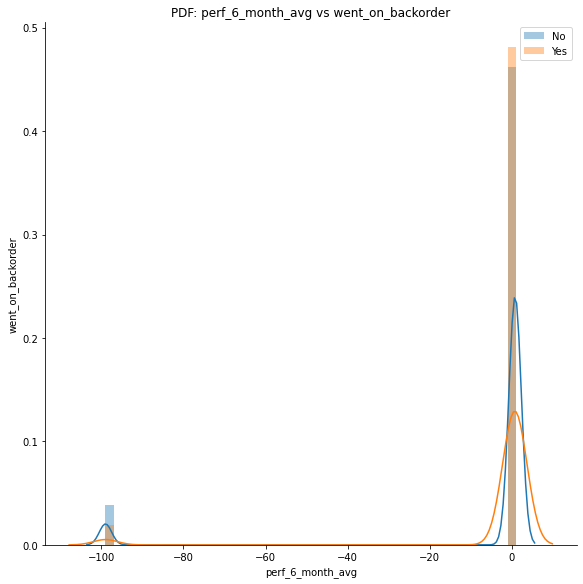

In [69]:
sns.FacetGrid(train, hue="went_on_backorder", height=8).map(sns.distplot, "perf_6_month_avg")
plt.title('PDF: perf_6_month_avg vs went_on_backorder')
plt.xlabel('perf_6_month_avg')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

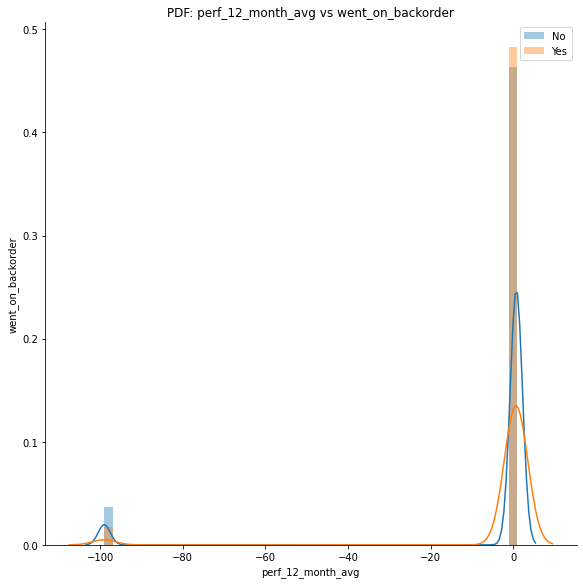

In [70]:
sns.FacetGrid(train, hue="went_on_backorder", height=8).map(sns.distplot, "perf_12_month_avg")
plt.title('PDF: perf_12_month_avg vs went_on_backorder')
plt.xlabel('perf_12_month_avg')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

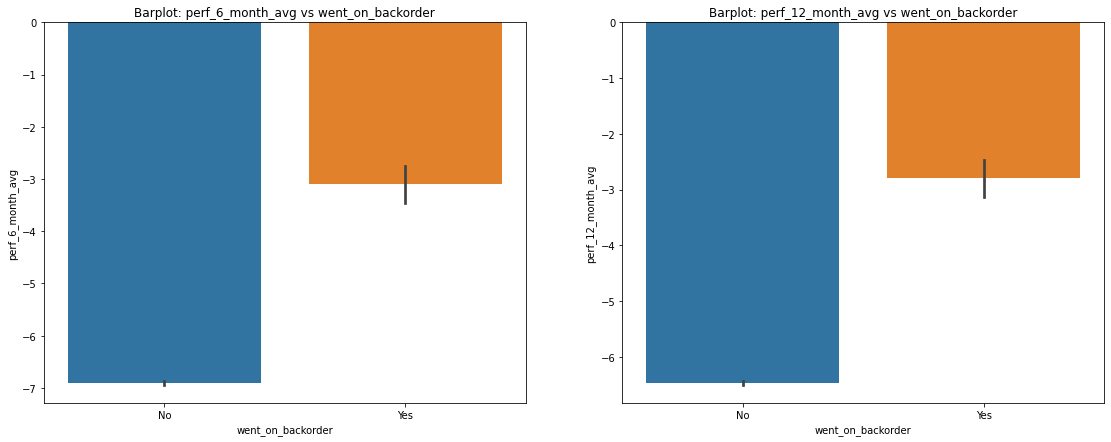

In [71]:
plt.figure(figsize=(19, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='went_on_backorder', y='perf_6_month_avg', orient='v', data=train)
plt.title('Barplot: perf_6_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_6_month_avg')

plt.subplot(1, 2, 2)
sns.barplot(x='went_on_backorder', y='perf_12_month_avg', orient='v', data=train)
plt.title('Barplot: perf_12_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_12_month_avg')

plt.show()

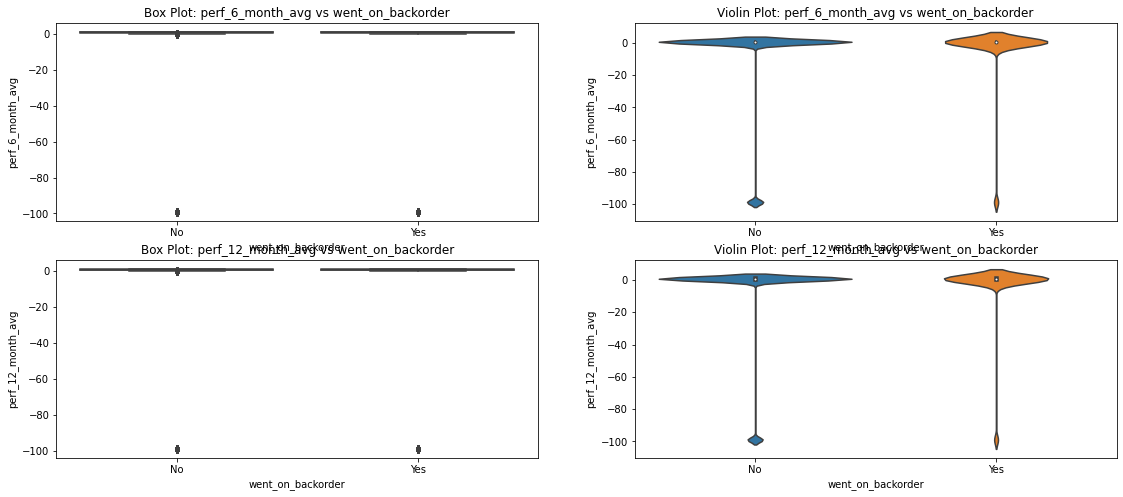

In [72]:
plt.figure(figsize=(19, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='went_on_backorder', y='perf_6_month_avg', data=train)
plt.title('Box Plot: perf_6_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_6_month_avg')

plt.subplot(2, 2, 2)
sns.violinplot(x='went_on_backorder', y='perf_6_month_avg', data=train)
plt.title('Violin Plot: perf_6_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_6_month_avg')

plt.subplot(2, 2, 3)
sns.boxplot(x='went_on_backorder', y='perf_12_month_avg', data=train)
plt.title('Box Plot: perf_12_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_12_month_avg')

plt.subplot(2, 2, 4)
sns.violinplot(x='went_on_backorder', y='perf_12_month_avg', data=train)
plt.title('Violin Plot: perf_12_month_avg vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('perf_12_month_avg')

plt.show()

In [73]:
#percentiles and quantiles
print("Quantiles for perf_6_month_avg:")
print("25th percentile:",np.percentile(train["perf_6_month_avg"],25)) #25th percentile
print("50th percentile:",np.percentile(train["perf_6_month_avg"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["perf_6_month_avg"],60)) #50th percentile
print("65th percentile:",np.percentile(train["perf_6_month_avg"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["perf_6_month_avg"],75)) #75th percentile
print("90th percentile:",np.percentile(train["perf_6_month_avg"],90)) #90th percentile

print("Quantiles for perf_12_month_avg:")
print("25th percentile:",np.percentile(train["perf_12_month_avg"],25)) #25th percentile
print("50th percentile:",np.percentile(train["perf_12_month_avg"],50)) #50th percentile or median
print("60th percentile:",np.percentile(train["perf_12_month_avg"],60)) #50th percentile
print("65th percentile:",np.percentile(train["perf_12_month_avg"],65)) #50th percentile 
print("75th percentile:",np.percentile(train["perf_12_month_avg"],75)) #75th percentile
print("90th percentile:",np.percentile(train["perf_12_month_avg"],90)) #90th percentile

Quantiles for perf_6_month_avg:
25th percentile: 0.63
50th percentile: 0.82
60th percentile: 0.89
65th percentile: 0.9200000000000002
75th percentile: 0.97
90th percentile: 0.99
Quantiles for perf_12_month_avg:
25th percentile: 0.66
50th percentile: 0.81
60th percentile: 0.8700000000000001
65th percentile: 0.9000000000000001
75th percentile: 0.95
90th percentile: 0.99


#### Observations:
We see that the pdf for the two features 'perf_6_month_avg' and 'perf_12_month_avg' are very similar. We see a gaussian-like distribution for both the features around zero. However, the curve extend extremely towards the negative axis indicating negative skewness. From the barplots, we see that the average source performance over 6 and 12 months is around -3 for the orders that went into backorder and around -6 to -7 for the orders which did not go into backorder. 

The box and violin plots also indicate that the distribution in negatively skewed and there are a few outliers for both the classes. The median value for 'perf_6_month_avg' and 'perf_12_month_avg' is 0.82 and 0.81 respectively and 90% percent of the points are less than 0.99 for both the features.

#### local_bo_qty vs went_on_backorder

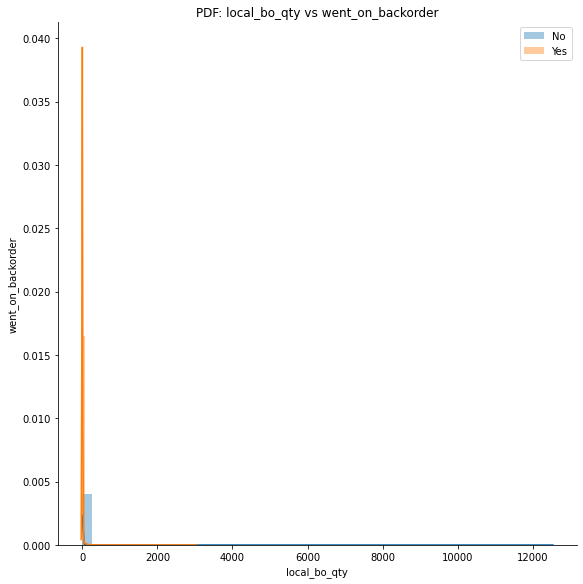

In [74]:
sns.FacetGrid(train, hue="went_on_backorder", height=8).map(sns.distplot, "local_bo_qty")
plt.title('PDF: local_bo_qty vs went_on_backorder')
plt.xlabel('local_bo_qty')
plt.ylabel('went_on_backorder')
plt.legend()
plt.show()

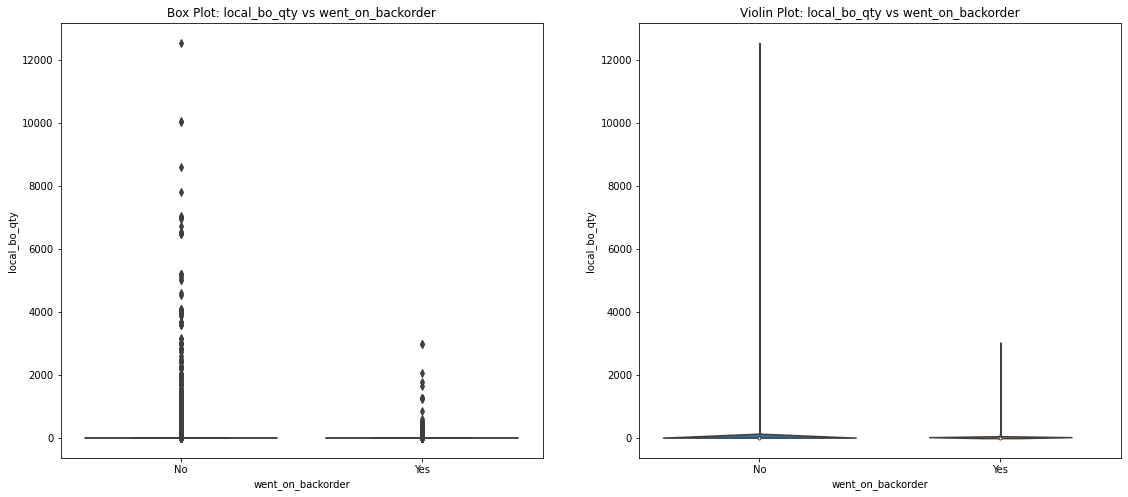

In [75]:
plt.figure(figsize=(19, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='went_on_backorder', y='local_bo_qty', data=train)
plt.title('Box Plot: local_bo_qty vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('local_bo_qty')

plt.subplot(1, 2, 2)
sns.violinplot(x='went_on_backorder', y='local_bo_qty', data=train)
plt.title('Violin Plot: local_bo_qty vs went_on_backorder')
plt.xlabel('went_on_backorder')
plt.ylabel('local_bo_qty')

plt.show()

In [76]:
#percentiles and quantiles
print("Quantiles for local_bo_qty:")
print("25th percentile:",np.percentile(train["local_bo_qty"],25)) #25th percentile
print("50th percentile:",np.percentile(train["local_bo_qty"],50)) #50th percentile or median
print("75th percentile:",np.percentile(train["local_bo_qty"],75)) #75th percentile
print("90th percentile:",np.percentile(train["local_bo_qty"],90)) #90th percentile
print("95th percentile:",np.percentile(train["local_bo_qty"],95)) #95th percentile
print("98th percentile:",np.percentile(train["local_bo_qty"],98)) #98th percentile
print("99th percentile:",np.percentile(train["local_bo_qty"],99)) #99th percentile

Quantiles for local_bo_qty:
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 0.0
90th percentile: 0.0
95th percentile: 0.0
98th percentile: 0.0
99th percentile: 1.0


#### Observations:
When we look at the pdf for the feature, we see that the majority of datapoints are at zero. This is further confirmed with the box and violin plots. To find the exact values, we have calculated the percentiles. We see that 98% pecent of the datapoints are equal to zero and 99% of the datapoint are less than or equal to 1. That makes this feature a sparse feature. We will be looking at correlation matrices further in our EDA process to better understand the impact each feature has with each other and with the target. 

#### deck_risk, oe_constraint, ppap_risk, stop_auto_buy and rev_stop vs went_on_backorder

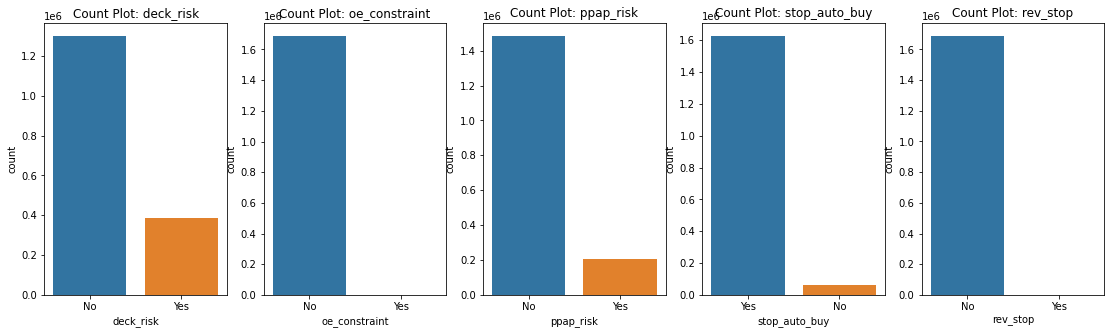

In [77]:
plt.figure(figsize=(19, 5))

plt.subplot(1, 5, 1)
sns.countplot(train['deck_risk'])
plt.title('Count Plot: deck_risk')

plt.subplot(1, 5, 2)
sns.countplot(train['oe_constraint'])
plt.title('Count Plot: oe_constraint')

plt.subplot(1, 5, 3)
sns.countplot(train['ppap_risk'])
plt.title('Count Plot: ppap_risk')

plt.subplot(1, 5, 4)
sns.countplot(train['stop_auto_buy'])
plt.title('Count Plot: stop_auto_buy')

plt.subplot(1, 5, 5)
sns.countplot(train['rev_stop'])
plt.title('Count Plot: rev_stop')

plt.show()

#### Observations:
From the count plots above, we clearly there are very less number of datapoints with the risk flags 'oe_constraint' and 'rev_stop'. There are a decent number of datapoints with 'deck_risk' as 'Yes'. And, a considerable amount of datapoints with 'ppap_risk' and 'stop_auto_buy' as 'Yes'. The majority of the datapoints do not have any risk flags in the train set. 

# Spearman Rank Correlation Coefficient

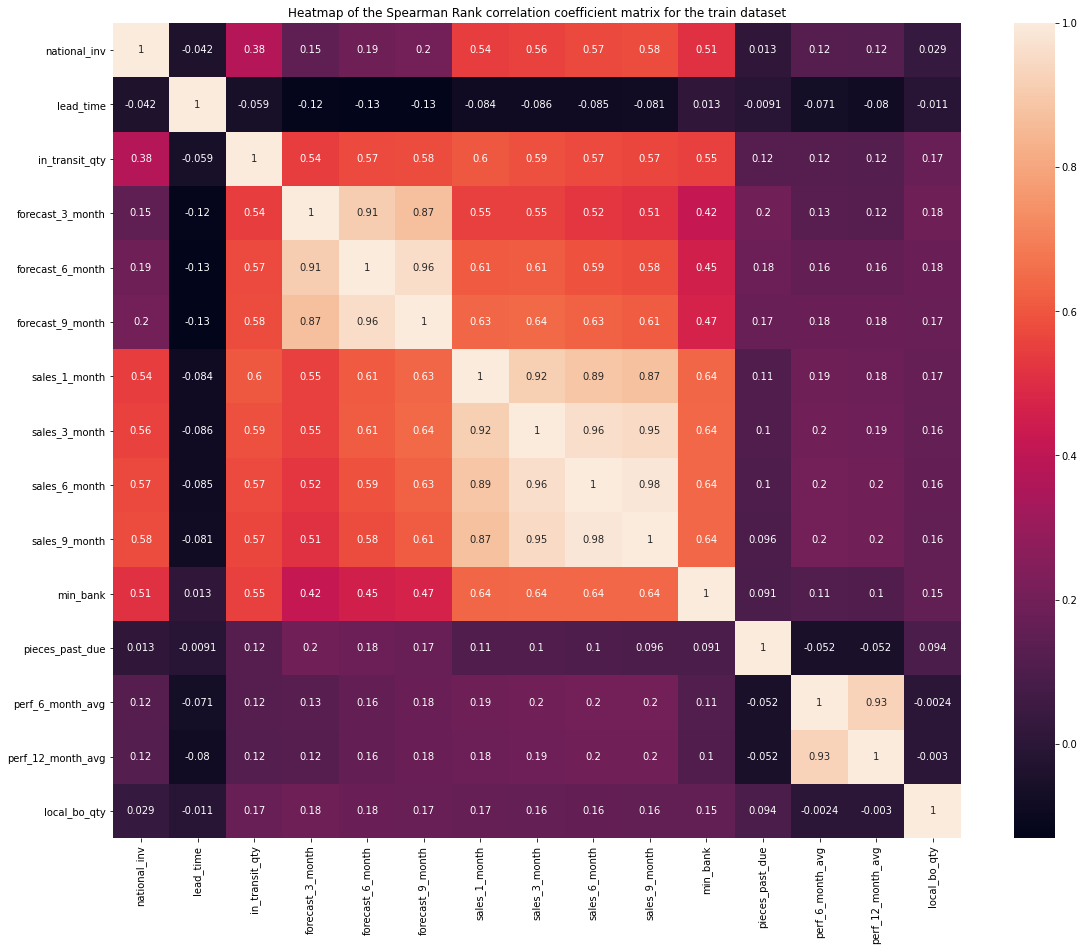

In [78]:
plt.figure(figsize=(19,15))
sns.heatmap(train.corr(method='spearman'), annot=True)
plt.title('Heatmap of the Spearman Rank correlation coefficient matrix for the train dataset')
plt.show()

#### Observations:
Here we have plotted the heatmaps of spearman rank correlation coefficient. We see that the 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month' and 'min_bank' are highly correlated with each other. Among them, 'forecast_3_month', 'forecast_6_month' and 'forecast_9_month' are more correlated with each other compared to the rest. Similarly, 'sales_1_month', 'sales_3_month', 'sales_6_month' and 'sales_9_month' are more correlated with each other than any other feature. Furthermore, we see that the 'perf_6_month_avg' and 'perf_12_month_avg' are highly correlated with each other.

# Kolmogorov–Smirnov test for numerical features

In [79]:
# we are going to seperate all the features based on the class label. since we have two class labels, the seperation will result in two distributionw
# we will compare the two distributions to find out how each feature is effecting the class label.

In [80]:
#national_inv
national_inv_vs_went_on_backorder = train.loc[:, ['national_inv', 'went_on_backorder']]
national_inv_0 = national_inv_vs_went_on_backorder[national_inv_vs_went_on_backorder['went_on_backorder'] == 'No']['national_inv']
national_inv_1 = national_inv_vs_went_on_backorder[national_inv_vs_went_on_backorder['went_on_backorder'] == 'Yes']['national_inv']

#lead_time
lead_time_vs_went_on_backorder = train.loc[:, ['lead_time', 'went_on_backorder']]
lead_time_0 = lead_time_vs_went_on_backorder[lead_time_vs_went_on_backorder['went_on_backorder'] == 'No']['lead_time']
lead_time_1 = lead_time_vs_went_on_backorder[lead_time_vs_went_on_backorder['went_on_backorder'] == 'Yes']['lead_time']

#in_transit_qty
in_transit_qty_vs_went_on_backorder = train.loc[:, ['in_transit_qty', 'went_on_backorder']]
in_transit_qty_0 = in_transit_qty_vs_went_on_backorder[in_transit_qty_vs_went_on_backorder['went_on_backorder'] == 'No']['in_transit_qty']
in_transit_qty_1 = in_transit_qty_vs_went_on_backorder[in_transit_qty_vs_went_on_backorder['went_on_backorder'] == 'Yes']['in_transit_qty']

#forecast_3_month
forecast_3_month_vs_went_on_backorder = train.loc[:, ['forecast_3_month', 'went_on_backorder']]
forecast_3_month_0 = forecast_3_month_vs_went_on_backorder[forecast_3_month_vs_went_on_backorder['went_on_backorder'] == 'No']['forecast_3_month']
forecast_3_month_1 = forecast_3_month_vs_went_on_backorder[forecast_3_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['forecast_3_month']

#forecast_6_month
forecast_6_month_vs_went_on_backorder = train.loc[:, ['forecast_6_month', 'went_on_backorder']]
forecast_6_month_0 = forecast_6_month_vs_went_on_backorder[forecast_6_month_vs_went_on_backorder['went_on_backorder'] == 'No']['forecast_6_month']
forecast_6_month_1 = forecast_6_month_vs_went_on_backorder[forecast_6_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['forecast_6_month']

#forecast_9_month
forecast_9_month_vs_went_on_backorder = train.loc[:, ['forecast_9_month', 'went_on_backorder']]
forecast_9_month_0 = forecast_9_month_vs_went_on_backorder[forecast_9_month_vs_went_on_backorder['went_on_backorder'] == 'No']['forecast_9_month']
forecast_9_month_1 = forecast_9_month_vs_went_on_backorder[forecast_9_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['forecast_9_month']

#sales_1_month
sales_1_month_vs_went_on_backorder = train.loc[:, ['sales_1_month', 'went_on_backorder']]
sales_1_month_0 = sales_1_month_vs_went_on_backorder[sales_1_month_vs_went_on_backorder['went_on_backorder'] == 'No']['sales_1_month']
sales_1_month_1 = sales_1_month_vs_went_on_backorder[sales_1_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['sales_1_month']

#sales_3_month
sales_3_month_vs_went_on_backorder = train.loc[:, ['sales_3_month', 'went_on_backorder']]
sales_3_month_0 = sales_3_month_vs_went_on_backorder[sales_3_month_vs_went_on_backorder['went_on_backorder'] == 'No']['sales_3_month']
sales_3_month_1 = sales_3_month_vs_went_on_backorder[sales_3_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['sales_3_month']

#sales_6_month
sales_6_month_vs_went_on_backorder = train.loc[:, ['sales_6_month', 'went_on_backorder']]
sales_6_month_0 = sales_6_month_vs_went_on_backorder[sales_6_month_vs_went_on_backorder['went_on_backorder'] == 'No']['sales_6_month']
sales_6_month_1 = sales_6_month_vs_went_on_backorder[sales_6_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['sales_6_month']

#sales_9_month
sales_9_month_vs_went_on_backorder = train.loc[:, ['sales_9_month', 'went_on_backorder']]
sales_9_month_0 = sales_9_month_vs_went_on_backorder[sales_9_month_vs_went_on_backorder['went_on_backorder'] == 'No']['sales_9_month']
sales_9_month_1 = sales_9_month_vs_went_on_backorder[sales_9_month_vs_went_on_backorder['went_on_backorder'] == 'Yes']['sales_9_month']

#min_bank
min_bank_vs_went_on_backorder = train.loc[:, ['min_bank', 'went_on_backorder']]
min_bank_0 = min_bank_vs_went_on_backorder[min_bank_vs_went_on_backorder['went_on_backorder'] == 'No']['min_bank']
min_bank_1 = min_bank_vs_went_on_backorder[min_bank_vs_went_on_backorder['went_on_backorder'] == 'Yes']['min_bank']

#pieces_past_due
pieces_past_due_vs_went_on_backorder = train.loc[:, ['pieces_past_due', 'went_on_backorder']]
pieces_past_due_0 = pieces_past_due_vs_went_on_backorder[pieces_past_due_vs_went_on_backorder['went_on_backorder'] == 'No']['pieces_past_due']
pieces_past_due_1 = pieces_past_due_vs_went_on_backorder[pieces_past_due_vs_went_on_backorder['went_on_backorder'] == 'Yes']['pieces_past_due']

#perf_6_month_avg
perf_6_month_avg_vs_went_on_backorder = train.loc[:, ['perf_6_month_avg', 'went_on_backorder']]
perf_6_month_avg_0 = perf_6_month_avg_vs_went_on_backorder[perf_6_month_avg_vs_went_on_backorder['went_on_backorder'] == 'No']['perf_6_month_avg']
perf_6_month_avg_1 = perf_6_month_avg_vs_went_on_backorder[perf_6_month_avg_vs_went_on_backorder['went_on_backorder'] == 'Yes']['perf_6_month_avg']

#perf_12_month_avg
perf_12_month_avg_vs_went_on_backorder = train.loc[:, ['perf_12_month_avg', 'went_on_backorder']]
perf_12_month_avg_0 = perf_12_month_avg_vs_went_on_backorder[perf_12_month_avg_vs_went_on_backorder['went_on_backorder'] == 'No']['perf_12_month_avg']
perf_12_month_avg_1 = perf_12_month_avg_vs_went_on_backorder[perf_12_month_avg_vs_went_on_backorder['went_on_backorder'] == 'Yes']['perf_12_month_avg']

#local_bo_qty
local_bo_qty_vs_went_on_backorder = train.loc[:, ['local_bo_qty', 'went_on_backorder']]
local_bo_qty_0 = local_bo_qty_vs_went_on_backorder[local_bo_qty_vs_went_on_backorder['went_on_backorder'] == 'No']['local_bo_qty']
local_bo_qty_1 = local_bo_qty_vs_went_on_backorder[local_bo_qty_vs_went_on_backorder['went_on_backorder'] == 'Yes']['local_bo_qty']

In [81]:
negative_class = [national_inv_0, lead_time_0, in_transit_qty_0, forecast_3_month_0, forecast_6_month_0, forecast_9_month_0, sales_1_month_0, 
                 sales_3_month_0, sales_6_month_0, sales_9_month_0, min_bank_0, pieces_past_due_0, perf_6_month_avg_0, perf_12_month_avg_0, 
                  local_bo_qty_0]

positive_class = [national_inv_1, lead_time_1, in_transit_qty_1, forecast_3_month_1, forecast_6_month_1, forecast_9_month_1, sales_1_month_1, 
                 sales_3_month_1, sales_6_month_1, sales_9_month_1, min_bank_1, pieces_past_due_1, perf_6_month_avg_1, perf_12_month_avg_1, 
                  local_bo_qty_1]

numerical_feature_names = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 
                  'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 
                  'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']

In [82]:
print("KS test results for all the features seperated with respect to went_on_backorder:")
for a, b, c in zip(negative_class, positive_class, numerical_feature_names):
    print(f"{c}:   {kstest(a, b)}")

KS test results for all the features seperated with respect to went_on_backorder:
national_inv:   KstestResult(statistic=0.45930388632022046, pvalue=0.0)
lead_time:   KstestResult(statistic=0.12358668797761088, pvalue=8.871901817096557e-150)
in_transit_qty:   KstestResult(statistic=0.08361356816437004, pvalue=1.1392587380049708e-68)
forecast_3_month:   KstestResult(statistic=0.5549223474821481, pvalue=0.0)
forecast_6_month:   KstestResult(statistic=0.5380446074846053, pvalue=0.0)
forecast_9_month:   KstestResult(statistic=0.5208074359304866, pvalue=0.0)
sales_1_month:   KstestResult(statistic=0.29399462478309996, pvalue=0.0)
sales_3_month:   KstestResult(statistic=0.3019551028675028, pvalue=0.0)
sales_6_month:   KstestResult(statistic=0.27980928163383156, pvalue=0.0)
sales_9_month:   KstestResult(statistic=0.26490500565360914, pvalue=0.0)
min_bank:   KstestResult(statistic=0.030669661309448926, pvalue=1.3363130686456096e-09)
pieces_past_due:   KstestResult(statistic=0.07816384395447284

In [83]:
seperated_dfs = [national_inv_vs_went_on_backorder, lead_time_vs_went_on_backorder, in_transit_qty_vs_went_on_backorder, forecast_3_month_vs_went_on_backorder,
forecast_6_month_vs_went_on_backorder, forecast_9_month_vs_went_on_backorder, sales_1_month_vs_went_on_backorder, sales_3_month_vs_went_on_backorder,
sales_6_month_vs_went_on_backorder, sales_9_month_vs_went_on_backorder, min_bank_vs_went_on_backorder, pieces_past_due_vs_went_on_backorder,
perf_6_month_avg_vs_went_on_backorder, perf_12_month_avg_vs_went_on_backorder, local_bo_qty_vs_went_on_backorder]

15it [00:17,  1.19s/it]


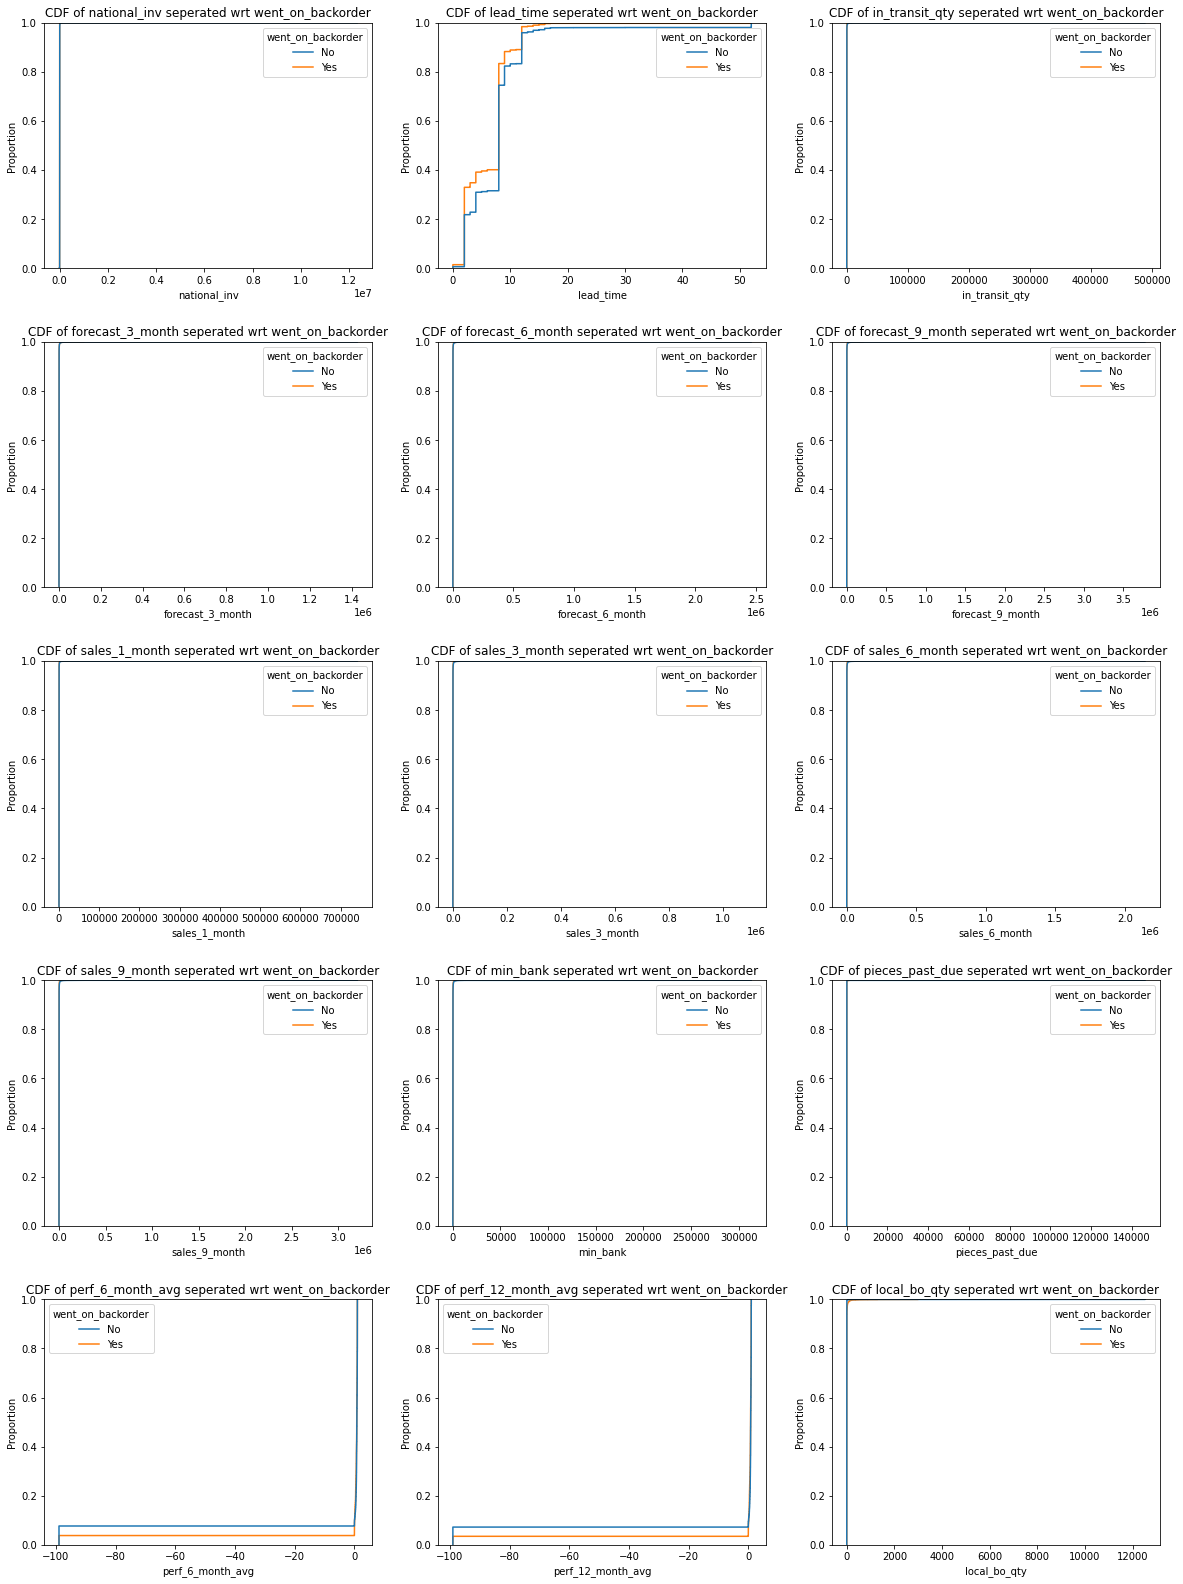

In [84]:
plt.figure(figsize=(20, 28))
for x, y, z in tqdm(zip(range(1,16), numerical_feature_names, seperated_dfs)):
    plt.subplot(5, 3, x)
    plt.subplots_adjust(hspace=0.3)
    sns.ecdfplot(z, x=y, hue='went_on_backorder')
    plt.title(f'CDF of {y} seperated wrt went_on_backorder')
plt.show()

#### Observations:
We can see that most of the feature have very high number of datapoints at 0. From the ks test for all the numerical feature we can say most of the features do not have a very good p values and thus we will have to reject the null hypothesis. Therefore, these distributions are not similar are do not show much correlation with the target variable.

However, some features like lead_time, perf_6_month_avg, perf_12_month_avg show good enough correlation with the target variable.

# Stochastic/Probability Matrix for categorical features

In [85]:
train.replace({'Yes': 1, 'No': 0}, inplace=True)

In [86]:
potential_issue_vs_went_on_backorder = train.loc[:, ['potential_issue', 'went_on_backorder']]
x = np.array(potential_issue_vs_went_on_backorder)

potential_issue_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x), 
                                                x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                               [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x), 
                                                x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

potential_issue_probability_matrix = pd.DataFrame(potential_issue_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

In [87]:
deck_risk_vs_went_on_backorder = train.loc[:, ['deck_risk', 'went_on_backorder']]
x = np.array(deck_risk_vs_went_on_backorder)

deck_risk_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x),
                                          x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                         [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x),
                                          x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

deck_risk_probability_matrix = pd.DataFrame(deck_risk_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

In [88]:
oe_constraint_vs_went_on_backorder = train.loc[:, ['oe_constraint', 'went_on_backorder']]
x = np.array(oe_constraint_vs_went_on_backorder)

oe_constraint_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x),
                                              x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                             [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x),
                                              x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

oe_constraint_probability_matrix = pd.DataFrame(oe_constraint_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

In [89]:
ppap_risk_vs_went_on_backorder = train.loc[:, ['ppap_risk', 'went_on_backorder']]
x = np.array(ppap_risk_vs_went_on_backorder)

ppap_risk_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x),
                                          x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                         [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x),
                                          x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

ppap_risk_probability_matrix = pd.DataFrame(ppap_risk_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

In [90]:
stop_auto_buy_vs_went_on_backorder = train.loc[:, ['stop_auto_buy', 'went_on_backorder']]
x = np.array(stop_auto_buy_vs_went_on_backorder)

stop_auto_buy_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x),
                                              x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                             [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x),
                                              x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

stop_auto_buy_probability_matrix = pd.DataFrame(stop_auto_buy_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

In [91]:
rev_stop_vs_went_on_backorder = train.loc[:, ['rev_stop', 'went_on_backorder']]
x = np.array(rev_stop_vs_went_on_backorder)

rev_stop_probability_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x),
                                             x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                            [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x),
                                             x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

rev_stop_probability_matrix = pd.DataFrame(rev_stop_probability_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])

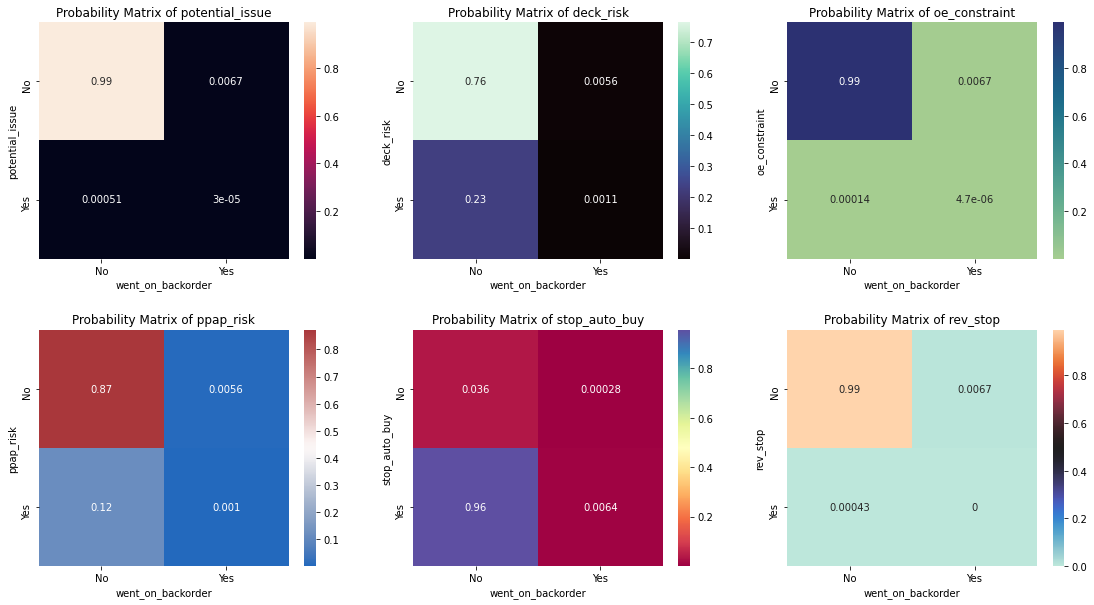

In [92]:
plt.figure(figsize=(19, 10))
plt.subplot(2, 3, 1)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(potential_issue_probability_matrix, annot=True, cmap='rocket')
plt.title("Probability Matrix of potential_issue")
plt.xlabel('went_on_backorder')
plt.ylabel('potential_issue')

plt.subplot(2, 3, 2)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(deck_risk_probability_matrix, annot=True, cmap='mako')
plt.title("Probability Matrix of deck_risk")
plt.xlabel('went_on_backorder')
plt.ylabel('deck_risk')

plt.subplot(2, 3, 3)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(oe_constraint_probability_matrix, annot=True, cmap='crest')
plt.title("Probability Matrix of oe_constraint")
plt.xlabel('went_on_backorder')
plt.ylabel('oe_constraint')

plt.subplot(2, 3, 4)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(ppap_risk_probability_matrix, annot=True, cmap='vlag')
plt.title("Probability Matrix of ppap_risk")
plt.xlabel('went_on_backorder')
plt.ylabel('ppap_risk')

plt.subplot(2, 3, 5)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(stop_auto_buy_probability_matrix, annot=True, cmap='Spectral')
plt.title("Probability Matrix of stop_auto_buy")
plt.xlabel('went_on_backorder')
plt.ylabel('stop_auto_buy')

plt.subplot(2, 3, 6)
plt.subplots_adjust(hspace=0.3)
sns.heatmap(rev_stop_probability_matrix, annot=True, cmap='icefire')
plt.title("Probability Matrix of rev_stop")
plt.xlabel('went_on_backorder')
plt.ylabel('rev_stop')

plt.show()

In [93]:
#saving to csv so we can use it for building the model
potential_issue_probability_matrix.to_csv('potential_issue_probability_matrix.csv', index=False)
deck_risk_probability_matrix.to_csv('deck_risk_probability_matrix.csv', index=False)
oe_constraint_probability_matrix.to_csv('oe_constraint_probability_matrix.csv', index=False)
ppap_risk_probability_matrix.to_csv('ppap_risk_probability_matrix.csv', index=False)
stop_auto_buy_probability_matrix.to_csv('stop_auto_buy_probability_matrix.csv', index=False)
rev_stop_probability_matrix.to_csv('rev_stop_probability_matrix.csv', index=False)

#### Observations:
From the above set of probaility matrices for all the categorical features we see that most of these categorical features have a very high probability of having a negetive flag when the product did not go into backorder. Therefore, we can say that when a product does not go into backorder, most of the general risk flag are negative.

# Dimensionality Reduction

### Principal Component Analysis

In [94]:
#we will perform pca for all the data points which do not have missing values

In [95]:
x_train = train.dropna().drop('went_on_backorder', axis=1)
y_train = train.dropna()['went_on_backorder']

In [96]:
standard_scalar = StandardScaler()

In [97]:
std_x_train = standard_scalar.fit_transform(x_train)

In [98]:
model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(std_x_train)
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data=pca_data, columns=("principal_component_1", "principal_component_2", "went_on_backorder"))

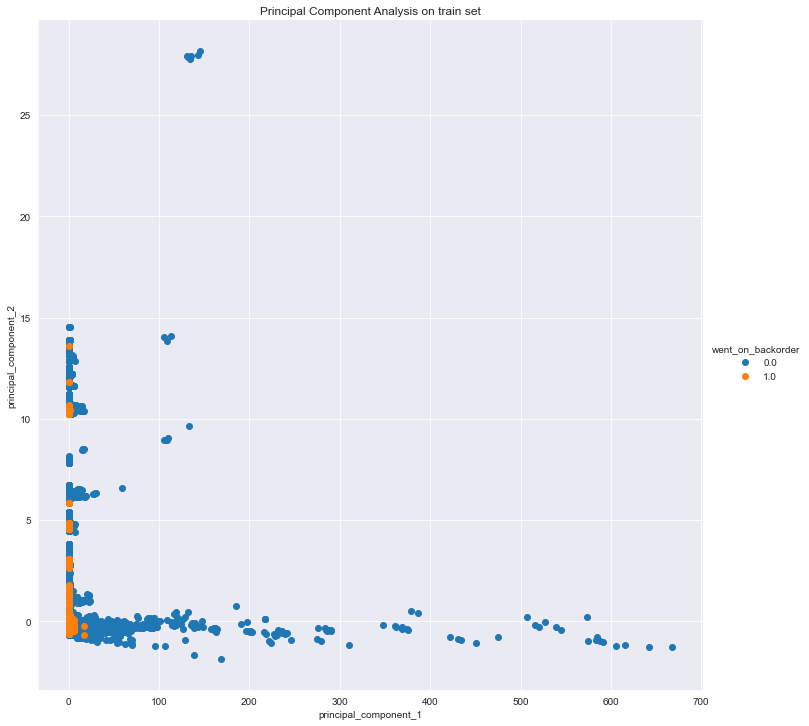

In [99]:
sns.set_style("darkgrid")
sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'principal_component_1', 'principal_component_2').add_legend()
plt.title("Principal Component Analysis on train set")
plt.show()

#### Observations:
We have used dimensionality reduction techniques, in this case Principal Component Analysis to capture the essence of the data. From the above plot we see that most of the datapoints lie alongside 0. This deduction is true because we have seen many features with mostly 0 values in our EDA. There are outliers in the data but those datapoints does not have to be outlier per se. Furthermore, these potential outliers are more of the negative class compared to the positive class. And, for the positive class, almost all of the datapoints lie alongside 0.

# Feature Engineering

In [100]:
# we will first perfrom missing values imputation

In [101]:
train = train.fillna(np.mean(train['lead_time'])) #mean imputation

In [102]:
lead_time_mean = np.array(np.mean(train['lead_time']))

In [103]:
np.save('lead_time_mean.npy', lead_time_mean)

We have performed mean impuations for the feature lead_time. Furthermore, we saw that the feature pieces_past_due and local_bo_quantity has more than 95% of values as 0. Therefore, as a feature engineering process we can add another feature which shows if each datapoint in the two features is zero or non-zero.

In [104]:
train['pieces_past_due'].value_counts()

0.0       1662571
1.0          3917
2.0          2187
4.0          1294
3.0          1217
           ...   
8106.0          1
1652.0          1
928.0           1
557.0           1
294.0           1
Name: pieces_past_due, Length: 826, dtype: int64

In [105]:
conditions = [train['pieces_past_due'] == 0, train['pieces_past_due'] > 0]
values = [0, 1]

In [106]:
train['binary_pieces_past_due'] = np.select(conditions, values)

In [107]:
train['binary_pieces_past_due'].value_counts()

0    1662571
1      25289
Name: binary_pieces_past_due, dtype: int64

In [108]:
train['local_bo_qty'].value_counts()

0.0      1664518
1.0         7151
2.0         2982
3.0         1716
4.0         1224
          ...   
860.0          1
532.0          1
249.0          1
662.0          1
507.0          1
Name: local_bo_qty, Length: 654, dtype: int64

In [109]:
conditions = [train['local_bo_qty'] == 0, train['local_bo_qty'] > 0]
values = [0, 1]

In [110]:
train['binary_local_bo_qty'] = np.select(conditions, values)

In [111]:
train['binary_local_bo_qty'].value_counts()

0    1664518
1      23342
Name: binary_local_bo_qty, dtype: int64

We have added two new features which show us if the datapoint in pieces_past_due and local_bo_quantity is a zero value or a non-zero value respectively. For further feature engineering we will impute the zero values in all categorical features with the respective probability values from the probability matrices we calculated above.

In [112]:
conditions_pt = [train['potential_issue'] == 0, train['potential_issue'] == 1]
values_pt = [potential_issue_probability_matrix['No'][0], potential_issue_probability_matrix['No'][1]]

train['potential_issue'] = np.select(conditions_pt, values_pt)

In [113]:
train['potential_issue'].value_counts()

0.992802    1686953
0.000507        907
Name: potential_issue, dtype: int64

In [114]:
conditions_dr = [train['deck_risk'] == 0, train['deck_risk'] == 1]
values_dr = [deck_risk_probability_matrix['No'][0], deck_risk_probability_matrix['No'][1]]

train['deck_risk'] = np.select(conditions_dr, values_dr)

In [115]:
train['deck_risk'].value_counts()

0.764874    1300377
0.228435     387483
Name: deck_risk, dtype: int64

In [116]:
conditions_oe = [train['oe_constraint'] == 0, train['oe_constraint'] == 1]
values_oe = [oe_constraint_probability_matrix['No'][0], oe_constraint_probability_matrix['No'][1]]

train['oe_constraint'] = np.select(conditions_oe, values_oe)

In [117]:
train['oe_constraint'].value_counts()

0.993169    1687615
0.000140        245
Name: oe_constraint, dtype: int64

In [118]:
conditions_pp = [train['ppap_risk'] == 0, train['ppap_risk'] == 1]
values_pp = [ppap_risk_probability_matrix['No'][0], ppap_risk_probability_matrix['No'][1]]

train['ppap_risk'] = np.select(conditions_pp, values_pp)

In [119]:
train['ppap_risk'].value_counts()

0.873587    1484026
0.119723     203834
Name: ppap_risk, dtype: int64

In [120]:
conditions_stp = [train['stop_auto_buy'] == 0, train['stop_auto_buy'] == 1]
values_stp = [stop_auto_buy_probability_matrix['No'][0], stop_auto_buy_probability_matrix['No'][1]]

train['stop_auto_buy'] = np.select(conditions_stp, values_stp)

In [121]:
train['stop_auto_buy'].value_counts()

0.957397    1626774
0.035912      61086
Name: stop_auto_buy, dtype: int64

In [122]:
conditions_rev = [train['rev_stop'] == 0, train['rev_stop'] == 1]
values_rev = [rev_stop_probability_matrix['No'][0], rev_stop_probability_matrix['No'][1]]

train['rev_stop'] = np.select(conditions_rev, values_rev)

In [123]:
train['rev_stop'].value_counts()

0.992876    1687129
0.000433        731
Name: rev_stop, dtype: int64

Now we will perform the same preprocessing and feature engineering steps for the test dataset. We will make sure the all the values imputed the test set are calculated from the train set to ensure there is no data leakage.

In [124]:
test.drop('sku', axis=1, inplace=True)

In [125]:
test = test.fillna(np.mean(train['lead_time'])) #train mean imputation

In [126]:
test.replace({'Yes': 1, 'No': 0}, inplace=True) #converting categorical features to binary features

In [127]:
conditions = [test['pieces_past_due'] == 0, test['pieces_past_due'] > 0]
values = [0, 1]

test['binary_pieces_past_due'] = np.select(conditions, values)

conditions = [test['local_bo_qty'] == 0, test['local_bo_qty'] > 0]
values = [0, 1]

test['binary_local_bo_qty'] = np.select(conditions, values)

In [128]:
conditions_pt = [test['potential_issue'] == 0, test['potential_issue'] == 1]
values_pt = [potential_issue_probability_matrix['No'][0], potential_issue_probability_matrix['No'][1]]
test['potential_issue'] = np.select(conditions_pt, values_pt)

conditions_dr = [test['deck_risk'] == 0, test['deck_risk'] == 1]
values_dr = [deck_risk_probability_matrix['No'][0], deck_risk_probability_matrix['No'][1]]
test['deck_risk'] = np.select(conditions_dr, values_dr)

conditions_oe = [test['oe_constraint'] == 0, test['oe_constraint'] == 1]
values_oe = [oe_constraint_probability_matrix['No'][0], oe_constraint_probability_matrix['No'][1]]
test['oe_constraint'] = np.select(conditions_oe, values_oe)

conditions_pp = [test['ppap_risk'] == 0, test['ppap_risk'] == 1]
values_pp = [ppap_risk_probability_matrix['No'][0], ppap_risk_probability_matrix['No'][1]]
test['ppap_risk'] = np.select(conditions_pp, values_pp)

conditions_stp = [test['stop_auto_buy'] == 0, test['stop_auto_buy'] == 1]
values_stp = [stop_auto_buy_probability_matrix['No'][0], stop_auto_buy_probability_matrix['No'][1]]
test['stop_auto_buy'] = np.select(conditions_stp, values_stp)

conditions_rev = [test['rev_stop'] == 0, test['rev_stop'] == 1]
values_rev = [rev_stop_probability_matrix['No'][0], rev_stop_probability_matrix['No'][1]]
test['rev_stop'] = np.select(conditions_rev, values_rev)

In [129]:
print("The final dataset we can use to build a machine learning model is as follows, where the column 'went_on_backorder' is our target label:\n")
train

The final dataset we can use to build a machine learning model is as follows, where the column 'went_on_backorder' is our target label:



,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
2,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
3,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
4,8.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.0,2.000000,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,...,0.69,5.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,1
1687856,-1.0,7.872267,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,...,-99.00,1.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,1
1687857,-1.0,9.000000,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,...,0.84,1.0,0.228435,0.993169,0.873587,0.035912,0.992876,1,0,1
1687858,62.0,9.000000,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,...,0.84,6.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,1


In [130]:
test

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,62.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
1,9.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.119723,0.035912,0.992876,0,0,0
2,17.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
3,9.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.75,0.0,0.764874,0.993169,0.119723,0.957397,0.992876,0,0,0
4,2.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.71,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,12.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.48,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
242071,13.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.48,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
242072,13.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.48,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
242073,10.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.48,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0


In [131]:
train.to_csv('preprocessed_train.csv')

In [132]:
test.to_csv('preprocessed_test.csv')

In [133]:
# now we will plot PCA after feature engineering
x_train = train.dropna().drop('went_on_backorder', axis=1)
y_train = train.dropna()['went_on_backorder']

In [134]:
standard_scalar = StandardScaler()

In [135]:
std_x_train = standard_scalar.fit_transform(x_train)

In [136]:
model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(std_x_train)
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data=pca_data, columns=("principal_component_1", "principal_component_2", "went_on_backorder"))

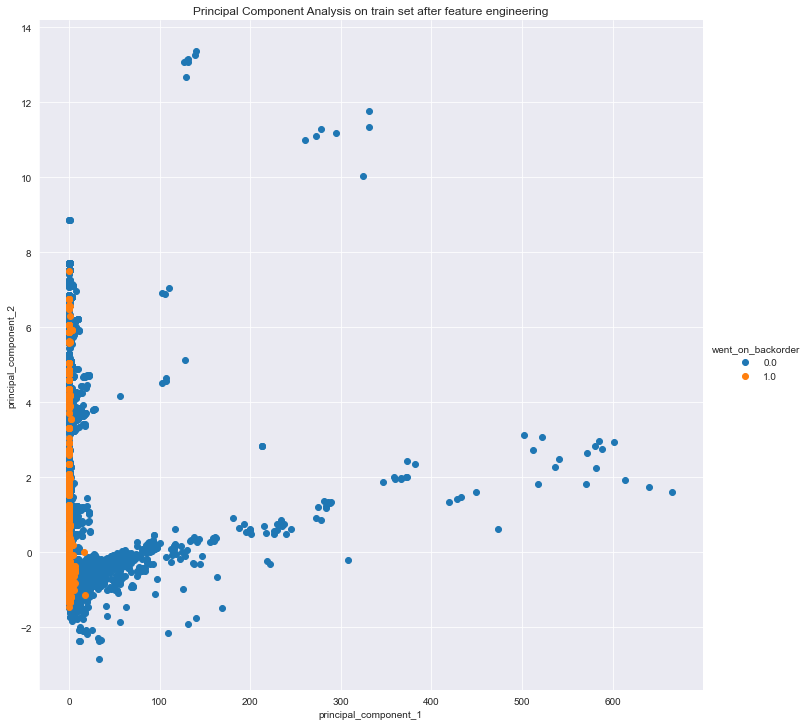

In [137]:
sns.set_style("darkgrid")
sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'principal_component_1', 'principal_component_2').add_legend()
plt.title("Principal Component Analysis on train set after feature engineering")
plt.show()

#### Observations:
We see some seperation and also overlap between the positive class and the negative class. This means that the model we build should be able to farily distinguish between a product that went backorder versus a product that did not go into backorder.

<h1><p style="text-align: center;">_____________________</p></h1>